In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
# from catboost import CatBoostClassifier
from sklearn.feature_selection import SelectFromModel

## Reading, preprocessing, and splitting the data

Demographic data was not used as it led to poorer results. It also increased the number of features present in the final models, making interpretation of the result more difficult. Thus, we dropped demographic data altogether in favour of using trade area data which contain very similar information.

In [2]:
poi = pd.read_csv('../../data/Smoothie_King_Preprocessed/processed_poi.csv')
stores = pd.read_csv('../../data/Smoothie King/smoothie_king_stores.csv')
trade_area = pd.read_csv("../../data/Smoothie_King_Preprocessed/processed_trade_area.csv")
merged = stores.merge(trade_area, left_on="store", right_on="store_num").merge(poi)
merged = merged.drop(columns=["store_num", "country_code"])
merged = merged.set_index("store")

In [3]:
merged = merged.drop(columns=["longitude", "latitude", "state_name", "cbsa_name", "dma_name"])
merged = merged.dropna()

Encode the target column `category` so that we may pass it into OVR classifiers.

In [4]:
le = LabelEncoder()
merged["category"] = le.fit_transform(merged["category"])
merged

,category,market_size,store_density,age0018_p_ta,age65pl_p_ta,age85pl_p_ta,asian_p_ta,avg_faminc_ta,avghhinc_ta,black_p_ta,...,osm_highway_exits_count_3mi,osm_highway_exits_count_5mi,osm_nearest_exit_dist,places_of_worship_10mi,places_of_worship_1mi,places_of_worship_2mi,places_of_worship_3mi,places_of_worship_5mi,transitstop_nearest_dist,transitstops
store,,,,,,,,,,,,,,,,,,,,,
SK 1504,2,Large Metro (2),Light Suburban,0.2907,0.0909,0.0050,0.0555,108837.0,106093.0,0.0985,...,17,45,1.875541,314,5,30,76,128,14.818824,0
SK 0057,2,Medium City (4),Light Suburban,0.2416,0.1537,0.0134,0.0327,80752.0,70536.0,0.3890,...,3,14,2.617072,305,12,82,109,154,49.572856,0
SK 1415,0,Very Large Metro (1),Light Suburban,0.2198,0.1926,0.0147,0.0235,106893.0,97112.0,0.0552,...,25,45,0.194937,277,6,23,57,78,3.518308,0
SK 1231,3,Very Large Metro (1),Suburban,0.2060,0.2108,0.0185,0.0203,134373.0,149467.0,0.0998,...,31,61,1.393043,1202,10,50,116,393,0.021790,25
SK 1535,4,Very Large Metro (1),Light Suburban,0.2866,0.1283,0.0057,0.0719,102367.0,96066.0,0.1935,...,23,72,0.711949,903,12,58,117,273,0.055289,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SK 1536,0,Very Large Metro (1),Exurban,0.2745,0.1529,0.0111,0.0085,66363.0,59465.0,0.5114,...,36,81,0.261721,866,8,40,115,323,0.012345,24
SK 1886,1,Medium City (4),Light Suburban,0.2083,0.1078,0.0100,0.0304,95226.0,73773.0,0.0159,...,0,10,4.012518,175,20,71,112,128,0.189059,13
SK 0162,2,Very Large Metro (1),Exurban,0.2730,0.1367,0.0111,0.0172,89271.0,86552.0,0.1078,...,15,23,0.397305,140,20,42,53,68,0.699036,0


In [5]:
le.classes_

array(['HOME', 'OTHER', 'SHOPPING', 'TRAVEL', 'WORK'], dtype=object)

In [6]:
train_df, test_df = train_test_split(merged, test_size=0.1, random_state=42)
X_train = train_df.drop(columns=["category"])
y_train = train_df["category"]
X_test = test_df.drop(columns=["category"])
y_test = test_df["category"]

In [7]:
X_train

,market_size,store_density,age0018_p_ta,age65pl_p_ta,age85pl_p_ta,asian_p_ta,avg_faminc_ta,avghhinc_ta,black_p_ta,boomer_p_ta,...,osm_highway_exits_count_3mi,osm_highway_exits_count_5mi,osm_nearest_exit_dist,places_of_worship_10mi,places_of_worship_1mi,places_of_worship_2mi,places_of_worship_3mi,places_of_worship_5mi,transitstop_nearest_dist,transitstops
store,,,,,,,,,,,,,,,,,,,,,
SK 1190,Very Large Metro (1),Exurban,0.2969,0.1014,0.0071,0.0261,93118.0,89967.0,0.6010,0.1739,...,10,33,2.615653,746,4,13,53,162,1.748239,0
SK 1691,Very Large Metro (1),Exurban,0.2584,0.1199,0.0059,0.0633,72243.0,67727.0,0.5925,0.2033,...,14,21,0.388134,472,7,38,63,149,1.455125,0
SK 1429,Small Town (6),Exurban,0.2161,0.1461,0.0131,0.0151,73789.0,81607.0,0.4227,0.1953,...,0,0,7.056117,37,14,23,27,30,31.770532,0
SK 1469,Large City (3),Exurban,0.2736,0.1147,0.0083,0.0446,135460.0,134123.0,0.0187,0.1858,...,6,27,1.977634,153,4,14,23,48,1.319867,0
SK 0855,Very Large Metro (1),Light Suburban,0.2066,0.2145,0.0299,0.0209,104670.0,100387.0,0.0129,0.2525,...,16,46,1.326653,623,9,42,91,237,0.025833,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SK 1814,Very Large Metro (1),Exurban,0.2466,0.1358,0.0071,0.1914,137597.0,150433.0,0.1700,0.2253,...,14,29,0.203553,477,7,15,26,102,9.251025,0
SK 0977,Very Large Metro (1),Suburban,0.1881,0.1878,0.0199,0.0884,146098.0,161364.0,0.0730,0.2473,...,39,101,0.331632,1753,22,77,176,410,0.040567,11
SK 0328,Small City (5),Exurban,0.2144,0.1539,0.0150,0.0187,75062.0,62347.0,0.0340,0.1862,...,6,10,0.200039,48,5,15,26,40,44.211875,0


In [8]:
ordinal_features = ["market_size", "store_density"]
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

In [9]:
market_levels = [
    "Small Town (6)",
    "Small City (5)",
    "Medium City (4)",
    "Large City (3)",
    "Large Metro (2)",
    "Very Large Metro (1)"
]
density_levels = [
    "Rural",
    "Exurban",
    "Suburban",
    "Light Suburban",
    "Light Urban",
    "Urban",
    "Super Urban"
]

In [10]:
all_features = numeric_features + ordinal_features

In [11]:
ordinal_transformer = OrdinalEncoder(categories=[market_levels, density_levels], dtype=int)

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (ordinal_transformer, ordinal_features),
)

We define the class weights of the target class empirically looking at the distribution of each `category` class. In particular, we set similar weights to `HOME`, `SHOPPING`, and `WORK` to try and reduce the number of `HOME` predictions and increase the number of predictions for the other classes. The weights of `OTHER` and `TRAVEL` were set to be similar as well to increase the probability of predicting those classes.

In [12]:
class_weight = {
    "HOME": 0.24,
    "OTHER": 0.16,
    "SHOPPING": 0.22,
    "TRAVEL": 0.15,
    "WORK": 0.23
}
encoded_class_weights = {i: class_weight[label] for i, label in enumerate(le.classes_)}
class_weight = encoded_class_weights

## Build Logistic Regression Models

Perform hyperparameter optimization using `GridSearchCV`. Try the best 5 models after the search process and use the best scoring one out of the 5.

In [13]:
# pipe_lr = make_pipeline(
#     preprocessor,
#     LogisticRegression(penalty="l1", random_state=42, solver="saga", max_iter=10000, multi_class="ovr", n_jobs=-1)
# )
# param_lr = {
#     "logisticregression__C": [0.001, 0.01, 0.1, 1.0],
#     "logisticregression__multi_class": ["ovr", "multinomial"],
#     "logisticregression__penalty": ["l1", "l2"],
#     "logisticregression__class_weight": [None, "balanced", class_weight]
# }
# lr_grid_search = GridSearchCV(
#     pipe_lr, param_lr, cv=5, n_jobs=-1, return_train_score=True
# )
# lr_grid_search.fit(X_train, y_train);

In [14]:
# pd.DataFrame(lr_grid_search.cv_results_)[
#     [
#         "param_logisticregression__C",
#         "param_logisticregression__multi_class",
#         "param_logisticregression__class_weight",
#         "param_logisticregression__penalty",
#         "mean_fit_time",
#         "rank_test_score",
#         "mean_test_score",
#     ]
# ].set_index("rank_test_score").sort_index()

In [15]:
pipe_lr = make_pipeline(
    preprocessor,
    LogisticRegression(C=0.15, penalty="l2", random_state=42, solver="saga", max_iter=10000, multi_class="ovr", n_jobs=-1, class_weight=class_weight)
)
pipe_lr.fit(X_train, y_train);

In [16]:
pipe_lr.score(X_train, y_train)

0.652050919377652

In [17]:
pipe_lr.score(X_test, y_test)

0.6582278481012658

In [18]:
pipe_lr_multi = make_pipeline(
    preprocessor,
    LogisticRegression(C=0.1, penalty="l2", random_state=42, solver="saga", max_iter=10000, multi_class="multinomial", n_jobs=-1, 
                       class_weight=class_weight)
)
pipe_lr_multi.fit(X_train, y_train);

In [19]:
pipe_lr_multi.score(X_train, y_train)

0.6633663366336634

In [20]:
pipe_lr_multi.score(X_test, y_test)

0.6329113924050633

In [21]:
prediction_result = pd.DataFrame({
    "True label": y_test,
    "Logistic Regression (OVR)": pipe_lr.predict(X_test),
    "Logistic Regression (multinomial)": pipe_lr_multi.predict(X_test)
})

## Build Random Forest Models

### Basic RF model

Perform hyperparameter optimization using `RandomizedSearchCV`. Try the best 5 models after the search process and use the best scoring one out of the 5.

In [22]:
# pipe_rf = make_pipeline(
#     preprocessor,
#     RandomForestClassifier(n_jobs=-1, random_state=42)
# )
# rf_param_grid = {
#     "randomforestclassifier__n_estimators": [25, 50, 100, 150],
#     "randomforestclassifier__max_depth": [5, 10, 20, 30],
#     "randomforestclassifier__max_leaf_nodes": [30, 50, 70],
#     "randomforestclassifier__min_samples_leaf": [10, 20, 30, 40, 50],
#     "randomforestclassifier__min_samples_split": [10, 20, 30],
#     "randomforestclassifier__class_weight": [None, "balanced", class_weight]
# }
# rf_grid_search = RandomizedSearchCV(
#     pipe_rf, rf_param_grid, n_iter=30, cv=5, n_jobs=-1, return_train_score=True
# )
# rf_grid_search.fit(X_train, y_train);

In [23]:
# pd.DataFrame(rf_grid_search.cv_results_)[
#     [
#         "param_randomforestclassifier__n_estimators",
#         "param_randomforestclassifier__max_depth",
#         "param_randomforestclassifier__max_leaf_nodes",
#         "param_randomforestclassifier__min_samples_leaf",
#         "param_randomforestclassifier__min_samples_split",
#         "param_randomforestclassifier__class_weight",
#         "mean_fit_time",
#         "rank_test_score",
#         "mean_test_score",
#     ]
# ].set_index("rank_test_score").sort_index().head(10)

In [24]:
rf_tuned = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators=100, max_depth=30, max_leaf_nodes=30, class_weight=class_weight, 
                           min_samples_leaf=10, min_samples_split=30, n_jobs=-1, random_state=42)
)
rf_tuned.fit(X_train, y_train);

In [25]:
rf_tuned.score(X_train, y_train)

0.6888260254596889

In [26]:
rf_tuned.score(X_test, y_test)

0.6708860759493671

In [27]:
prediction_result["Random Forest"] = rf_tuned.predict(X_test)

In [28]:
# Takes long time to run

# rf_ovr_test = make_pipeline(
#     preprocessor,
#     SelectFromModel(
#         LogisticRegression(C=0.15, penalty="l2", random_state=42, solver="saga", max_iter=10000, multi_class="ovr", 
#                            n_jobs=-1, class_weight=class_weight)
#     ),
#     RandomForestClassifier(n_estimators=100, max_depth=30, max_leaf_nodes=30, class_weight="balanced", 
#                            min_samples_leaf=10, min_samples_split=30, n_jobs=-1, random_state=42)
# )
# rf_param_grid = {
#     "randomforestclassifier__n_estimators": [25, 50, 100, 150],
#     # "randomforestclassifier__max_features": ["sqrt", "log2", None],
#     "randomforestclassifier__max_features": [5, 10, 15, 20, 30],
#     "randomforestclassifier__max_depth": [5, 10, 20, 30],
#     "randomforestclassifier__max_leaf_nodes": [30, 50, 70],
#     "randomforestclassifier__min_samples_leaf": [10, 20, 30, 40, 50],
#     "randomforestclassifier__min_samples_split": [10, 20, 30, 40],
#     "randomforestclassifier__class_weight": [None, "balanced", class_weight]
# }
# rf_ovr_search = RandomizedSearchCV(
#     rf_ovr_test, rf_param_grid, n_iter=30, cv=5, n_jobs=-1, random_state=42
# )

In [29]:
# rf_ovr_search.fit(X_train, y_train);

In [30]:
# pd.DataFrame(rf_ovr_search.cv_results_)[
#     [
#         "param_randomforestclassifier__n_estimators",
#         "param_randomforestclassifier__max_features",
#         "param_randomforestclassifier__max_depth",
#         "param_randomforestclassifier__max_leaf_nodes",
#         "param_randomforestclassifier__min_samples_leaf",
#         "param_randomforestclassifier__min_samples_split",
#         "param_randomforestclassifier__class_weight",
#         "mean_fit_time",
#         "rank_test_score",
#         "mean_test_score",
#     ]
# ].set_index("rank_test_score").sort_values(by="mean_test_score", ascending=False)

In [31]:
# rf_ovr_search.best_params_

In [32]:
# rf_ovr_search.score(X_train, y_train)

In [33]:
# rf_ovr_search.score(X_test, y_test)

### RandomForest with regularization using LogisticRegression

In [34]:
pipe_lr_rf = make_pipeline(
    preprocessor,
    SelectFromModel(
        LogisticRegression(C=0.15, penalty="l2", random_state=42, solver="saga", max_iter=10000, multi_class="ovr", 
                           n_jobs=-1, class_weight=class_weight)
    ),
    RandomForestClassifier(n_estimators=100, max_depth=20, max_leaf_nodes=70, class_weight=class_weight, 
                           min_samples_leaf=10, min_samples_split=30, n_jobs=-1, random_state=42)
)
pipe_lr_rf.fit(X_train, y_train);

In [35]:
pipe_lr_rf.score(X_train, y_train)

0.6775106082036775

In [36]:
pipe_lr_rf.score(X_test, y_test)

0.6708860759493671

In [37]:
prediction_result["Random Forest (L2 reg with LR)"] = pipe_lr_rf.predict(X_test)

In [38]:
# pipe_lr_rf_test = make_pipeline(
#     preprocessor,
#     SelectFromModel(
#         LogisticRegression(C=0.15, penalty="l2", random_state=42, solver="saga", max_iter=10000, multi_class="ovr", 
#                            n_jobs=-1, class_weight=class_weight)
#     ),
#     RandomForestClassifier(n_estimators=100, max_depth=20, max_leaf_nodes=70, class_weight=class_weight, 
#                            min_samples_leaf=10, min_samples_split=30, n_jobs=-1, random_state=42)
# )

In [39]:
lr_rf_param = {
    "selectfrommodel__estimator__C": [0.1, 0.15, 0.2, 0.3, 0.4],
    "selectfrommodel__estimator__penalty": ["l1", "l2"],
    "selectfrommodel__estimator__multi_class": ["ovr", "multinomial"],
    "selectfrommodel__estimator__class_weight": [None, "balanced", class_weight]
}
lr_rf_search = RandomizedSearchCV(
    pipe_lr_rf, lr_rf_param, n_iter=30, cv=5, n_jobs=-1, random_state=42
)
lr_rf_search.fit(X_train, y_train);

In [40]:
pd.DataFrame(lr_rf_search.cv_results_)[
    [
        "param_selectfrommodel__estimator__C",
        "param_selectfrommodel__estimator__penalty",
        "param_selectfrommodel__estimator__multi_class",
        "param_selectfrommodel__estimator__class_weight",
        "mean_fit_time",
        "rank_test_score",
        "mean_test_score",
    ]
].set_index("rank_test_score").sort_index().head(10)

,param_selectfrommodel__estimator__C,param_selectfrommodel__estimator__penalty,param_selectfrommodel__estimator__multi_class,param_selectfrommodel__estimator__class_weight,mean_fit_time,mean_test_score
rank_test_score,,,,,,
1,0.1,l1,ovr,None,33.434972,0.451184
2,0.4,l1,multinomial,"{0: 0.24, 1: 0.16, 2: 0.22, 3: 0.15, 4: 0.23}",41.494185,0.446898
3,0.1,l2,ovr,balanced,29.718565,0.445550
4,0.2,l1,multinomial,"{0: 0.24, 1: 0.16, 2: 0.22, 3: 0.15, 4: 0.23}",50.666229,0.445520
5,0.3,l2,ovr,"{0: 0.24, 1: 0.16, 2: 0.22, 3: 0.15, 4: 0.23}",33.137065,0.444141
6,0.15,l2,ovr,None,26.171736,0.442723
6,0.1,l1,multinomial,balanced,27.958207,0.442723
8,0.4,l2,ovr,"{0: 0.24, 1: 0.16, 2: 0.22, 3: 0.15, 4: 0.23}",24.541852,0.441325
9,0.2,l1,multinomial,balanced,23.533175,0.441285


In [41]:
lr_rf_search.score(X_train, y_train)

0.6817538896746818

In [42]:
lr_rf_search.score(X_test, y_test)

0.6708860759493671

In [43]:
lr_rf_l1 = make_pipeline(
    preprocessor,
    SelectFromModel(
        LogisticRegression(C=0.1, penalty="l1", random_state=42, solver="saga", max_iter=10000, multi_class="ovr", 
                           n_jobs=-1, class_weight=None)
    ),
    RandomForestClassifier(n_estimators=100, max_depth=20, max_leaf_nodes=70, class_weight=class_weight, 
                           min_samples_leaf=10, min_samples_split=30, n_jobs=-1, random_state=42)
)
lr_rf_l1.fit(X_train, y_train);

In [44]:
print(lr_rf_l1.score(X_train, y_train))
print(lr_rf_l1.score(X_test, y_test))

0.6817538896746818
0.6708860759493671


In [45]:
prediction_result["Random Forest (L1 reg with LR)"] = lr_rf_l1.predict(X_test)

In [46]:
pipe_lr_rf_rank2 = make_pipeline(
    preprocessor,
    SelectFromModel(
        LogisticRegression(C=0.4, penalty="l1", random_state=42, solver="saga", max_iter=10000, multi_class="multinomial", 
                           n_jobs=-1, class_weight=class_weight)
    ),
    RandomForestClassifier(n_estimators=100, max_depth=20, max_leaf_nodes=70, class_weight=class_weight, 
                           min_samples_leaf=10, min_samples_split=30, n_jobs=-1, random_state=42)
)
pipe_lr_rf_rank2.fit(X_train, y_train);

In [47]:
print(pipe_lr_rf_rank2.score(X_train, y_train))
print(pipe_lr_rf_rank2.score(X_test, y_test))

0.669024045261669
0.6582278481012658


**Second best set of parameters do not lead to better result. Just use the best set of parameters.**

### Random Forest with OVR and regularization using LogisticRegression

In [48]:
lr_rf_ovr = make_pipeline(
    preprocessor,
    SelectFromModel(
        LogisticRegression(C=0.15, penalty="l2", random_state=42, solver="saga", max_iter=10000, multi_class="ovr", 
                           n_jobs=-1, class_weight=class_weight)
    ),
    OneVsRestClassifier(
        RandomForestClassifier(n_estimators=100, max_depth=30, max_leaf_nodes=30, class_weight=None, 
                               min_samples_leaf=10, min_samples_split=30, n_jobs=-1, random_state=42)
    )
)

In [49]:
lr_rf_ovr_search = RandomizedSearchCV(
    lr_rf_ovr, lr_rf_param, n_iter=30, cv=5, n_jobs=-1, random_state=42
)
lr_rf_ovr_search.fit(X_train, y_train);

In [50]:
pd.DataFrame(lr_rf_ovr_search.cv_results_)[
    [
        "param_selectfrommodel__estimator__C",
        "param_selectfrommodel__estimator__penalty",
        "param_selectfrommodel__estimator__multi_class",
        "param_selectfrommodel__estimator__class_weight",
        "mean_fit_time",
        "rank_test_score",
        "mean_test_score",
    ]
].set_index("rank_test_score").sort_values(by="mean_test_score", ascending=False).head(10)

,param_selectfrommodel__estimator__C,param_selectfrommodel__estimator__penalty,param_selectfrommodel__estimator__multi_class,param_selectfrommodel__estimator__class_weight,mean_fit_time,mean_test_score
rank_test_score,,,,,,
1,0.4,l1,multinomial,"{0: 0.24, 1: 0.16, 2: 0.22, 3: 0.15, 4: 0.23}",43.007910,0.466717
2,0.4,l2,ovr,"{0: 0.24, 1: 0.16, 2: 0.22, 3: 0.15, 4: 0.23}",23.623322,0.465328
3,0.1,l2,ovr,"{0: 0.24, 1: 0.16, 2: 0.22, 3: 0.15, 4: 0.23}",34.895501,0.463840
4,0.1,l2,multinomial,None,25.046915,0.462501
5,0.3,l1,multinomial,"{0: 0.24, 1: 0.16, 2: 0.22, 3: 0.15, 4: 0.23}",33.467128,0.461073
6,0.4,l1,ovr,"{0: 0.24, 1: 0.16, 2: 0.22, 3: 0.15, 4: 0.23}",35.451993,0.461053
7,0.2,l2,ovr,None,23.537985,0.459664
7,0.15,l1,ovr,None,30.080648,0.459664
9,0.1,l1,ovr,None,34.584460,0.459654


In [51]:
lr_rf_ovr_search.score(X_train, y_train)

0.7736916548797736

In [52]:
lr_rf_ovr_search.score(X_test, y_test)

0.6455696202531646

In [53]:
lr_rf_ovr = make_pipeline(
    preprocessor,
    SelectFromModel(
        LogisticRegression(C=0.15, penalty="l1", random_state=42, solver="saga", max_iter=10000, multi_class="multinomial", 
                           n_jobs=-1, class_weight=None)
    ),
    OneVsRestClassifier(
        RandomForestClassifier(n_estimators=100, max_depth=30, max_leaf_nodes=30, class_weight=None, 
                               min_samples_leaf=10, min_samples_split=30, n_jobs=-1, random_state=42)
    )
)
lr_rf_ovr.fit(X_train, y_train);

In [54]:
print(lr_rf_ovr.score(X_train, y_train))
print(lr_rf_ovr.score(X_test, y_test))

0.7835926449787836
0.6708860759493671


In [55]:
prediction_result["Random Forest (OVR with L1 reg using LR)"] = lr_rf_ovr.predict(X_test)

In [56]:
rf_ovr = make_pipeline(
    preprocessor,
    OneVsRestClassifier(
        RandomForestClassifier(n_estimators=100, max_depth=30, max_leaf_nodes=30, class_weight="balanced", 
                           min_samples_leaf=10, min_samples_split=30, n_jobs=-1, random_state=42)
    )
)
rf_ovr.fit(X_train, y_train);

In [57]:
rf_ovr.score(X_train, y_train)

0.8642149929278642

In [58]:
rf_ovr.score(X_test, y_test)

0.6582278481012658

Model using just OVR is overfitted. Will not use.

In [59]:
# prediction_result["rf_ovr"] = rf_ovr.predict(X_test)

## LGBM Model - Poor score, won't use

In [60]:
# pipe_lgbm_ovr = make_pipeline(
#     preprocessor,
#     OneVsRestClassifier(
#         LGBMClassifier(random_state=42, n_jobs=-1)
#     )
# )
# param_lgbm = {
#     "onevsrestclassifier__estimator__n_estimators": [50, 100, 150, 200],
#     "onevsrestclassifier__estimator__boosting_type": ["gbdt", "dart"],
#     "onevsrestclassifier__estimator__learning_rate": [0.1, 0.3, 0.5, 0.7],
#     "onevsrestclassifier__estimator__max_depth": [5, 10, 15, 20],
#     "onevsrestclassifier__estimator__reg_alpha": [0.1, 0.3, 0.5, 0.7],
#     "onevsrestclassifier__estimator__reg_lambda": [0.1, 0.3, 0.5, 0.7],
#     # "onevsrestclassifier__estimator__min_child_samples": [20, 30, 40, 50],
#     "onevsrestclassifier__estimator__num_leaves": [5, 10, 15, 20],
#     "onevsrestclassifier__estimator__min_data_in_leaf": [30, 40, 50, 60],
#     "onevsrestclassifier__estimator__class_weight": [None, "balanced"]
# }
# lgbm_search = RandomizedSearchCV(
#     pipe_lgbm_ovr, param_lgbm, n_iter=30, cv=5, n_jobs=-1, random_state=42
# )

In [61]:
# lgbm_search.fit(X_train, y_train);

In [62]:
# pd.DataFrame(lgbm_search.cv_results_)[
#     [
#         "param_onevsrestclassifier__estimator__n_estimators",
#         "param_onevsrestclassifier__estimator__boosting_type",
#         "param_onevsrestclassifier__estimator__learning_rate",
#         "param_onevsrestclassifier__estimator__max_depth",
#         "param_onevsrestclassifier__estimator__reg_alpha",
#         "param_onevsrestclassifier__estimator__reg_lambda",
#         "param_onevsrestclassifier__estimator__class_weight",
#         # "param_onevsrestclassifier__estimator__min_child_samples",
#         "param_onevsrestclassifier__estimator__num_leaves",
#         "param_onevsrestclassifier__estimator__min_data_in_leaf",
#         "mean_fit_time",
#         "rank_test_score",
#         "mean_test_score",
#     ]
# ].set_index("rank_test_score").sort_index().head(20)

In [63]:
# lgbm_search.score(X_train, y_train)

In [64]:
# lgbm_search.score(X_test, y_test)

In [65]:
# lgbm_test = make_pipeline(
#     preprocessor,
#     OneVsRestClassifier(
#         LGBMClassifier(random_state=42, n_jobs=-1, n_estimators=150, boosting_type="gbdt", learning_rate=0.1, max_depth=10,
#                       reg_alpha=0.7, reg_lambda=0.7, num_leaves=20, min_data_in_leaf=30, class_weight=None)
#     )
# )
# lgbm_test.fit(X_train, y_train);

In [66]:
# lgbm_test.score(X_train, y_train)

In [67]:
# lgbm_test.score(X_test, y_test)

In [68]:
# lgbm_search.best_params_
# score=0.62025

## XGB Model - poor score, won't use

In [69]:
# pipe_xgb = make_pipeline(
#     preprocessor,
#     OneVsRestClassifier(
#         XGBClassifier(random_state=42, verbosity=0)
#     )
# )
# param_xgb = {
#     "onevsrestclassifier__estimator__booster": ["gbtree", "dart"],
#     "onevsrestclassifier__estimator__learning_rate": [0.1, 0.3, 0.5, 0.7],
#     "onevsrestclassifier__estimator__max_depth": [3, 5, 7, 9],
#     "onevsrestclassifier__estimator__reg_alpha": [0.1, 0.3, 0.5, 0.7],
#     "onevsrestclassifier__estimator__reg_lambda": [0.1, 0.3, 0.5, 0.7],
#     "onevsrestclassifier__estimator__subsample": [0.3, 0.5, 0.7, 1],
#     "onevsrestclassifier__estimator__min_child_weight": [1, 4, 7, 10]
# }
# xgb_search = RandomizedSearchCV(
#     pipe_xgb, param_xgb, n_iter=30, cv=5, n_jobs=-1, random_state=42
# )

In [70]:
# xgb_search.fit(X_train, y_train);

In [71]:
# pd.DataFrame(xgb_search.cv_results_)[
#     [
#         "param_onevsrestclassifier__estimator__booster",
#         "param_onevsrestclassifier__estimator__learning_rate",
#         "param_onevsrestclassifier__estimator__max_depth",
#         "param_onevsrestclassifier__estimator__reg_alpha",
#         "param_onevsrestclassifier__estimator__reg_lambda",
#         "param_onevsrestclassifier__estimator__subsample",
#         "param_onevsrestclassifier__estimator__min_child_weight",
#         "mean_fit_time",
#         "rank_test_score",
#         "mean_test_score",
#     ]
# ].set_index("rank_test_score").sort_index().head(20)

In [72]:
# xgb_search.score(X_train, y_train)

In [73]:
# xgb_search.score(X_test, y_test)

In [74]:
# xgb_test = make_pipeline(
#     preprocessor,
#     OneVsRestClassifier(
#         XGBClassifier(random_state=42, verbosity=0, booster="gbtree", learning_rate=0.1, max_depth=5, reg_alpha=0.5, reg_lambda=0.1,
#                      subsample=0.7, min_child_weight=1)
#     )
# )
# xgb_test.fit(X_train, y_train);

In [75]:
# xgb_test.score(X_train, y_train)

In [76]:
# xgb_test.score(X_test, y_test)
# XGBClassifier(random_state=42, verbosity=0, booster="gbtree", learning_rate=0.1, max_depth=5, reg_alpha=0.5, reg_lambda=0.1,
#                     subsample=0.7)

In [77]:
# lr_xgb_test = make_pipeline(
#     preprocessor,
#     SelectFromModel(
#         LogisticRegression(C=0.15, penalty="l2", random_state=42, solver="saga", max_iter=10000, multi_class="ovr", 
#                            n_jobs=-1, class_weight=class_weight)
#     ),
#     OneVsRestClassifier(
#         XGBClassifier(random_state=42, verbosity=0, booster="gbtree", learning_rate=0.1, max_depth=5, reg_alpha=0.5, reg_lambda=0.1,
#                      subsample=0.7)
#     )
# )
# lr_xgb_test.fit(X_train, y_train);

In [78]:
# lr_xgb_test.score(X_train, y_train)

In [79]:
# lr_xgb_test.score(X_test, y_test)

In [80]:
# prediction_result["xgb"] = xgb_test.predict(X_test)

In [81]:
prediction_result.head(20)

,True label,Logistic Regression (OVR),Logistic Regression (multinomial),Random Forest,Random Forest (L2 reg with LR),Random Forest (L1 reg with LR),Random Forest (OVR with L1 reg using LR)
store,,,,,,,
SK 1772,2,2,2,0,0,0,0
SK 0762,0,0,0,0,0,0,0
SK 1054,0,0,0,0,0,0,0
SK 0744,0,2,4,0,2,0,2
SK 1328,4,4,4,4,4,4,4
SK 1216,0,0,0,0,0,0,0
SK 1125,4,4,4,4,4,4,1
SK 0484,2,2,2,2,2,2,2
SK 1700,4,4,4,4,4,4,4


In [82]:
prediction_result.iloc[20:50]

,True label,Logistic Regression (OVR),Logistic Regression (multinomial),Random Forest,Random Forest (L2 reg with LR),Random Forest (L1 reg with LR),Random Forest (OVR with L1 reg using LR)
store,,,,,,,
SK 1500,2,0,0,0,0,0,0
SK 0556,2,2,2,2,2,2,2
SK 1907,0,0,0,0,0,0,0
SK 1360,1,4,4,4,4,4,4
SK 1237,2,2,2,2,2,2,2
SK 1179,0,0,0,0,0,2,0
SK 1516,2,2,2,2,2,2,2
SK 0699,0,0,0,0,0,0,0
SK 1571,3,1,1,4,4,4,4


In [83]:
prediction_result.iloc[50:]

,True label,Logistic Regression (OVR),Logistic Regression (multinomial),Random Forest,Random Forest (L2 reg with LR),Random Forest (L1 reg with LR),Random Forest (OVR with L1 reg using LR)
store,,,,,,,
SK 1948,4,4,4,4,4,4,4
SK 1536,0,2,2,2,0,4,0
SK 0900,0,0,0,4,0,0,0
SK 0471,4,4,4,4,4,4,4
SK 0507,0,0,0,0,2,0,2
SK 0970,2,2,2,2,2,2,2
SK 1634,2,2,2,2,2,2,2
SK 1821,4,4,1,0,0,2,0
SK 2005,1,2,2,2,2,2,2


## Try two different combinations of ensembling models

### 1: RF + RF (OVR, L1) + RF(L1)

In [84]:
classifiers_1 = {
    "rf": rf_tuned,
    "lr_rf_ovr": lr_rf_ovr,
    "lr_rf_l1": lr_rf_l1
}
classifiers_2 = {
    "rf": rf_tuned,
    "lr_rf": pipe_lr_rf,
    "lr_rf_l1": lr_rf_l1
}

In [85]:
averaging_model = VotingClassifier(
    list(classifiers_1.items()), voting="soft"
)
averaging_model.fit(X_train, y_train);

In [86]:
averaging_model.score(X_train, y_train)

0.7171145685997171

In [87]:
averaging_model.score(X_test, y_test)

0.6962025316455697

In [88]:
averaging_model_hard = VotingClassifier(
    list(classifiers_1.items()), voting="hard"
)
averaging_model_hard.fit(X_train, y_train);

In [89]:
averaging_model_hard.score(X_train, y_train)

0.7072135785007072

In [90]:
averaging_model_hard.score(X_test, y_test)

0.7088607594936709

In [91]:
stacking_model = StackingClassifier(list(classifiers_1.items()))
stacking_model.fit(X_train, y_train);

In [92]:
stacking_model.score(X_train, y_train)

0.7312588401697313

In [93]:
stacking_model.score(X_test, y_test)

0.6329113924050633

In [94]:
stack_rf = StackingClassifier(list(classifiers_1.items()), RandomForestClassifier(n_jobs=-1, random_state=42))
stack_rf.fit(X_train, y_train);

In [95]:
stack_rf.score(X_train, y_train)

0.6803394625176803

In [96]:
stack_rf.score(X_test, y_test)

0.6329113924050633

### 2: RF + RF (L2) + RF(L1)

In [97]:
averaging_model_2 = VotingClassifier(
    list(classifiers_2.items()), voting="soft"
)
averaging_model_2.fit(X_train, y_train);

In [98]:
averaging_model_2.score(X_train, y_train)

0.6902404526166902

In [99]:
averaging_model_2.score(X_test, y_test)

0.6708860759493671

In [100]:
averaging_model_hard_2 = VotingClassifier(
    list(classifiers_2.items()), voting="hard"
)
averaging_model_hard_2.fit(X_train, y_train);

In [101]:
averaging_model_hard_2.score(X_train, y_train)

0.6845827439886846

In [102]:
averaging_model_hard_2.score(X_test, y_test)

0.6962025316455697

In [103]:
stacking_model_2 = StackingClassifier(list(classifiers_1.items()))
stacking_model_2.fit(X_train, y_train);

In [104]:
stacking_model_2.score(X_train, y_train)

0.7312588401697313

In [105]:
stacking_model_2.score(X_test, y_test)

0.6329113924050633

In [106]:
stack_rf_2 = StackingClassifier(list(classifiers_1.items()), RandomForestClassifier(n_jobs=-1, random_state=42))
stack_rf_2.fit(X_train, y_train);

In [107]:
stack_rf_2.score(X_train, y_train)

0.6803394625176803

In [108]:
stack_rf_2.score(X_test, y_test)

0.6329113924050633

The best performing ensemble model is the first set of models using hard voting.

## Examine features used by best model

In [109]:
rf_tuned_feature_importance = pd.DataFrame(
    rf_tuned.named_steps['randomforestclassifier'].feature_importances_,
    index=all_features
).sort_values(by=0, ascending=False)
rf_tuned_feature_importance.head(10)

,0
emp_p_ta,0.043217
dtpop_children_at_home_p_ta,0.024727
centerxy_full_gla_1mi,0.021405
dtpop_students_9th_12th_p_ta,0.020858
dtpop_students_prek_8th_p_ta,0.016060
centerxy_full_0p5_intersect_gla,0.015414
hrsa_number_of_certified_beds_2mi,0.014702
dmm_gla_1mi,0.014668
dtpop_retired_disabled_p_ta,0.014322
dtpop_work_at_home_p_ta,0.014148


In [110]:
len(lr_rf_l1.named_steps['randomforestclassifier'].feature_importances_)

103

In [111]:
lr_rf_l1_selected = lr_rf_l1.named_steps['selectfrommodel'].get_support()
lr_rf_l1_selected_features = [feat for (feat, is_selected) in zip(all_features, lr_rf_l1_selected) if is_selected]
lr_rf_l1_feature_importance = pd.DataFrame(
    lr_rf_l1.named_steps['randomforestclassifier'].feature_importances_,
    index=lr_rf_l1_selected_features
).sort_values(by=0, ascending=False)
lr_rf_l1_feature_importance.head(10)

,0
emp_p_ta,0.063927
centerxy_full_0p5_intersect_gla,0.031018
dtpop_work_at_home_p_ta,0.028581
centerxy_full_0p5_intersect_count,0.028162
dtpop_retired_disabled_p_ta,0.025666
dtpop_unemployed_p_ta,0.025513
crime_total_index_ta,0.024608
ipeds_postsecondary_schools_total_enrollment_3mi,0.023571
centerxy_full_gla_1mi,0.023262
hrsa_number_of_certified_beds_2mi,0.021760


In [112]:
for i in range(len(lr_rf_ovr.named_steps['onevsrestclassifier'].estimators_)):
    print(len(lr_rf_ovr.named_steps['onevsrestclassifier'].estimators_[i].feature_importances_))

130
130
130
130
130


In [113]:
lr_rf_ovr_selected = lr_rf_ovr.named_steps['selectfrommodel'].get_support()
lr_rf_ovr_selected_features = [feat for (feat, is_selected) in zip(all_features, lr_rf_ovr_selected) if is_selected]
lr_rf_ovr_feature_importance = pd.DataFrame({
    "HOME": lr_rf_ovr.named_steps['onevsrestclassifier'].estimators_[0].feature_importances_,
    "OTHER": lr_rf_ovr.named_steps['onevsrestclassifier'].estimators_[1].feature_importances_,
    "SHOPPING": lr_rf_ovr.named_steps['onevsrestclassifier'].estimators_[2].feature_importances_,
    "TRAVEL": lr_rf_ovr.named_steps['onevsrestclassifier'].estimators_[3].feature_importances_,
    "WORK": lr_rf_ovr.named_steps['onevsrestclassifier'].estimators_[4].feature_importances_
}, index=lr_rf_ovr_selected_features)
lr_rf_ovr_feature_importance

,HOME,OTHER,SHOPPING,TRAVEL,WORK
age0018_p_ta,0.009073,0.006190,0.005119,0.048678,0.003732
age85pl_p_ta,0.004893,0.003982,0.002039,0.002418,0.002362
black_p_ta,0.009974,0.001615,0.016388,0.000484,0.006240
com0002_p_ta,0.025359,0.003578,0.003573,0.005240,0.022623
com0205_p_ta,0.014398,0.002996,0.009221,0.004981,0.007603
...,...,...,...,...,...
osm_nearest_exit_dist,0.004254,0.009724,0.005691,0.006389,0.001636
transitstop_nearest_dist,0.005128,0.009136,0.004347,0.011484,0.014152
transitstops,0.002257,0.002423,0.001532,0.000930,0.002694
market_size,0.005334,0.001004,0.001061,0.012318,0.003200


In [114]:
lr_rf_ovr_feature_importance[["HOME"]].sort_values(by="HOME", ascending=False).head(10)

,HOME
emp_p_ta,0.068548
dtpop_retired_disabled_p_ta,0.035051
pop_transient_ta,0.032379
dtpop_students_9th_12th_p_ta,0.027404
dtpop_work_at_home_p_ta,0.027245
dtpop_unemployed_p_ta,0.026026
hh_0vehicle_p_ta,0.025461
com0002_p_ta,0.025359
emp_educ_services_p_ta,0.023910
hh_3pers_p_ta,0.023129


In [115]:
lr_rf_ovr_feature_importance[["OTHER"]].sort_values(by="OTHER", ascending=False).head(10)

,OTHER
centerxy_full_0p5_intersect_gla,0.046731
hrsa_number_of_certified_beds_3mi,0.040955
ipeds_postsecondary_schools_total_enrollment_1mi,0.039672
ipeds_postsecondary_schools_3mi,0.030282
centerxy_full_nearest_dist,0.024310
edu_bachplus_p_ta,0.021456
hrsa_number_of_certified_beds_5mi,0.019978
edu_assocdeg_p_ta,0.019370
hrsa_number_of_certified_beds_2mi,0.019365
hrsa_hospitals_nearest_dist,0.017351


In [116]:
lr_rf_ovr_feature_importance[["SHOPPING"]].sort_values(by="SHOPPING", ascending=False).head(10)

,SHOPPING
centerxy_full_0p5_intersect_gla,0.062258
centerxy_full_gla_1mi,0.061865
dmm_count_1mi,0.050824
dmm_nearest_dist,0.026498
centerxy_full_0p5_intersect_count,0.026283
centerxy_full_nearest_dist,0.022373
centerxy_full_gla_3mi,0.020586
emp_retail_trade_p_ta,0.018372
centerxy_gla_effective_2mi,0.017442
black_p_ta,0.016388


In [117]:
lr_rf_ovr_feature_importance[["TRAVEL"]].sort_values(by="TRAVEL", ascending=False).head(10)

,TRAVEL
genx_p_ta,0.064772
hh_type_nonfam_p_ta,0.048883
age0018_p_ta,0.048678
poverty_inpoverty_p_ta,0.042562
nces_public_schools_nearest_dist,0.037700
hh_2pers_p_ta,0.033705
ipeds_postsecondary_schools_total_enrollment_2mi,0.030281
nces_public_schools_total_enrollment_10mi,0.029622
pop_seasonal_ta,0.027556
hu_vacant_ta,0.025927


In [118]:
lr_rf_ovr_feature_importance[["WORK"]].sort_values(by="WORK", ascending=False).head(10)

,WORK
emp_p_ta,0.051941
dtpop_work_at_home_p_ta,0.041628
dtpop_students_9th_12th_p_ta,0.028215
com0002_p_ta,0.022623
crime_total_index_ta,0.021865
poverty_inpoverty_p_ta,0.020929
centerxy_gla_effective_3mi,0.018400
emp_wholesale_trade_p_ta,0.018323
centerxy_full_nearest_dist,0.017915
emp_manfacturing_p_ta,0.015794


In [119]:
pipe_lr.named_steps['logisticregression'].coef_

array([[-0.03191046,  0.03078444, -0.00909258, ...,  0.14915485,
         0.13086501,  0.00093062],
       [ 0.00593491, -0.01439243, -0.05805205, ..., -0.05059905,
        -0.12200323, -0.0316698 ],
       [ 0.04248838, -0.05698709,  0.02447002, ..., -0.04239244,
        -0.14330206, -0.11479628],
       [-0.0743549 ,  0.00643303,  0.07205439, ...,  0.02261271,
        -0.70338488, -0.31951041],
       [ 0.02580378,  0.027293  , -0.02909045, ..., -0.08837481,
        -0.32305743, -0.02375686]])

In [120]:
lr_feature_importance = pd.DataFrame({
    "HOME": pipe_lr.named_steps['logisticregression'].coef_[0],
    "OTHER": pipe_lr.named_steps['logisticregression'].coef_[1],
    "SHOPPING": pipe_lr.named_steps['logisticregression'].coef_[2],
    "TRAVEL": pipe_lr.named_steps['logisticregression'].coef_[3],
    "WORK": pipe_lr.named_steps['logisticregression'].coef_[4]
}, index=all_features)
lr_feature_importance

,HOME,OTHER,SHOPPING,TRAVEL,WORK
age0018_p_ta,-0.031910,0.005935,0.042488,-0.074355,0.025804
age65pl_p_ta,0.030784,-0.014392,-0.056987,0.006433,0.027293
age85pl_p_ta,-0.009093,-0.058052,0.024470,0.072054,-0.029090
asian_p_ta,0.022446,-0.017614,-0.037982,-0.023955,0.044936
avg_faminc_ta,0.077683,-0.016418,-0.021589,-0.000093,-0.007304
...,...,...,...,...,...
places_of_worship_5mi,0.009047,-0.008627,0.006277,0.020766,-0.030915
transitstop_nearest_dist,-0.058536,0.037945,-0.143986,-0.006538,0.064718
transitstops,0.149155,-0.050599,-0.042392,0.022613,-0.088375
market_size,0.130865,-0.122003,-0.143302,-0.703385,-0.323057


In [121]:
lr_feature_importance[["HOME"]].sort_values(by="HOME", ascending=False)

,HOME
dtpop_retired_disabled_p_ta,0.221850
daypop_dens_ta,0.200181
hispanic_p_ta,0.194779
popgr10cn_ta,0.185273
dtpop_homemakers_p_ta,0.174490
...,...
com0205_p_ta,-0.179286
emp_p_ta,-0.186813
dmm_gla_10mi,-0.197070
dmm_count_1mi,-0.197642


In [122]:
lr_feature_importance[["OTHER"]].sort_values(by="OTHER", ascending=False)

,OTHER
ipeds_postsecondary_schools_total_enrollment_1mi,0.221405
ipeds_postsecondary_schools_5mi,0.159264
emp_arts_entertainment_p_ta,0.149586
ipeds_postsecondary_schools_3mi,0.147262
emp_transportation_storage_p_ta,0.142373
...,...
emp_construction_p_ta,-0.128463
centerxy_full_0p5_intersect_count,-0.181912
inrix_ns_distance,-0.185453
centerxy_full_0p5_intersect_gla,-0.207997


In [123]:
lr_feature_importance[["SHOPPING"]].sort_values(by="SHOPPING", ascending=False)

,SHOPPING
military_installations_1mi,0.229583
centerxy_full_0p5_intersect_gla,0.225647
nces_public_schools_1mi,0.160738
centerxy_full_count_3mi,0.148351
emp_other_p_ta,0.147714
...,...
osm_highway_exits_count_3mi,-0.155625
nces_private_schools_nearest_dist,-0.156659
hrsa_number_of_certified_beds_5mi,-0.158291
emp_accommodation_foodserv_p_ta,-0.164461


In [124]:
lr_feature_importance[["TRAVEL"]].sort_values(by="TRAVEL", ascending=False)

,TRAVEL
ipeds_postsecondary_schools_total_enrollment_2mi,0.161269
nces_public_schools_nearest_dist,0.150863
hh_type_nonfam_p_ta,0.131939
ipeds_postsecondary_schools_total_enrollment_1mi,0.120142
hu_vacant_ta,0.114098
...,...
age0018_p_ta,-0.074355
emp_wholesale_trade_p_ta,-0.076478
nces_public_schools_total_enrollment_1mi,-0.082145
store_density,-0.319510


In [125]:
lr_feature_importance[["WORK"]].sort_values(by="WORK", ascending=False)

,WORK
military_installations_2mi,0.208692
inrix_aadt_ew,0.200650
nces_public_schools_total_enrollment_10mi,0.184855
centerxy_gla_effective_10mi,0.174292
emp_p_ta,0.165026
...,...
nces_private_schools_total_enrollment_10mi,-0.185801
dtpop_unemployed_p_ta,-0.191755
centerxy_full_0p5_intersect_count,-0.196593
military_installations_10mi,-0.252598


## Interpretation for Random Forest Model

In [126]:
import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
import shap

C:\Users\ROG ZEPHYRUS\miniconda3\envs\capstone2023-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [127]:
y_test_index_reset = y_test.reset_index(drop=True)
class_0_indices = y_test_index_reset[y_test_index_reset == 0].index.tolist()
class_1_indices = y_test_index_reset[y_test_index_reset == 1].index.tolist()
class_2_indices = y_test_index_reset[y_test_index_reset == 2].index.tolist()
class_3_indices = y_test_index_reset[y_test_index_reset == 3].index.tolist()
class_4_indices = y_test_index_reset[y_test_index_reset == 4].index.tolist()

X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=all_features,
    index=X_test.index,
)
X_test_enc

,age0018_p_ta,age65pl_p_ta,age85pl_p_ta,asian_p_ta,avg_faminc_ta,avghhinc_ta,black_p_ta,boomer_p_ta,com0002_p_ta,com0205_p_ta,...,osm_nearest_exit_dist,places_of_worship_10mi,places_of_worship_1mi,places_of_worship_2mi,places_of_worship_3mi,places_of_worship_5mi,transitstop_nearest_dist,transitstops,market_size,store_density
store,,,,,,,,,,,,,,,,,,,,,
SK 1772,-0.757764,0.589757,0.602321,-0.264481,-0.560273,-0.676677,0.187879,0.959924,-0.584849,-0.175129,...,0.459339,0.910693,-0.210110,-0.017756,-0.064908,0.178062,-0.297469,-0.562677,5.0,3.0
SK 0762,-0.039123,-0.701547,-0.818166,-0.361227,-0.089653,0.004189,1.210538,0.109599,-0.978988,-1.033414,...,0.622862,-0.088100,-0.348079,-0.298812,-0.426522,-0.164322,-0.213922,-0.562677,5.0,1.0
SK 1054,-1.890643,1.341412,0.355790,0.158547,2.046363,1.817025,-0.943879,2.281857,-0.060176,-0.276487,...,0.520311,-0.215929,0.019840,-0.336286,-0.449852,-0.492032,-0.179921,-0.562677,5.0,1.0
SK 0744,-1.981650,3.080282,4.077230,-0.678025,0.138936,0.098668,-0.797614,1.636373,2.080340,1.743227,...,1.205616,-0.443420,-0.164120,-0.017756,0.366696,0.026435,-0.445713,1.009705,3.0,3.0
SK 1328,0.199378,0.176454,-0.055095,-0.793741,-1.069551,-0.943470,-0.603393,0.042907,0.217369,0.056413,...,-0.293146,-0.768406,-0.256099,-0.223864,-0.484847,-0.609421,-0.044960,-0.562677,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SK 1169,0.980783,-0.453137,-0.242928,-0.008388,0.694288,1.226194,-0.722083,-0.473957,0.245250,1.275494,...,-0.486390,2.208474,-0.118130,0.038455,0.226716,0.897067,-0.446298,1.102198,5.0,3.0
SK 1342,-0.183479,0.810328,0.989726,0.714365,0.173578,-0.128336,-0.313260,0.257275,0.058953,0.664558,...,-0.525192,-0.629745,-0.440059,-0.523656,-0.566502,-0.413773,-0.443491,0.084774,2.0,0.0
SK 1486,-0.829942,0.429147,-0.125532,-0.605939,-0.197518,-0.143177,-0.548843,0.552626,-1.001800,-0.527556,...,-0.458942,-0.621079,-0.026150,-0.336286,-0.461517,-0.506706,-0.268094,-0.562677,3.0,0.0


In [128]:
rf_explainer = shap.TreeExplainer(rf_tuned.named_steps["randomforestclassifier"])
test_rf_shap_values = rf_explainer.shap_values(X_test_enc)

In [129]:
test_rf_shap_values

[array([[ 3.18880705e-03,  1.60468677e-03,  1.16071276e-03, ...,
         -1.16851698e-03,  2.63253365e-03,  6.16157503e-05],
        [ 2.85152029e-04, -1.78272017e-03, -1.21293851e-03, ...,
         -4.24693524e-04,  1.43658109e-03,  1.27343301e-04],
        [ 3.04980916e-03,  6.64425205e-04, -4.84065418e-04, ...,
         -5.91557346e-04,  1.50805898e-03,  4.66084653e-04],
        ...,
        [ 2.39156660e-03,  9.79364806e-04, -6.69662899e-04, ...,
         -5.47885625e-04, -3.76450360e-03,  7.33632632e-05],
        [-1.07363168e-03,  6.23031537e-04, -4.04741987e-04, ...,
          7.10396718e-04,  8.82042098e-04, -2.08261200e-04],
        [-1.81254404e-03, -2.13195308e-03, -2.05561193e-04, ...,
         -4.21768701e-04,  1.35606206e-03,  1.27343301e-04]]),
 array([[-2.41268562e-04, -5.00820422e-04, -8.91692154e-04, ...,
          2.92253144e-04,  7.61262516e-04, -2.15597523e-05],
        [-6.05255676e-06,  5.64372908e-04,  4.96088387e-04, ...,
         -1.06004554e-06,  1.72825740e

In [130]:
rf_tuned.named_steps["randomforestclassifier"].predict(X_test_enc)[class_0_indices[0]]

0

In [131]:
rf_tuned.named_steps["randomforestclassifier"].predict_proba(X_test_enc)[class_0_indices[0]]

array([0.7882963 , 0.04309745, 0.10179855, 0.01585701, 0.05095068])

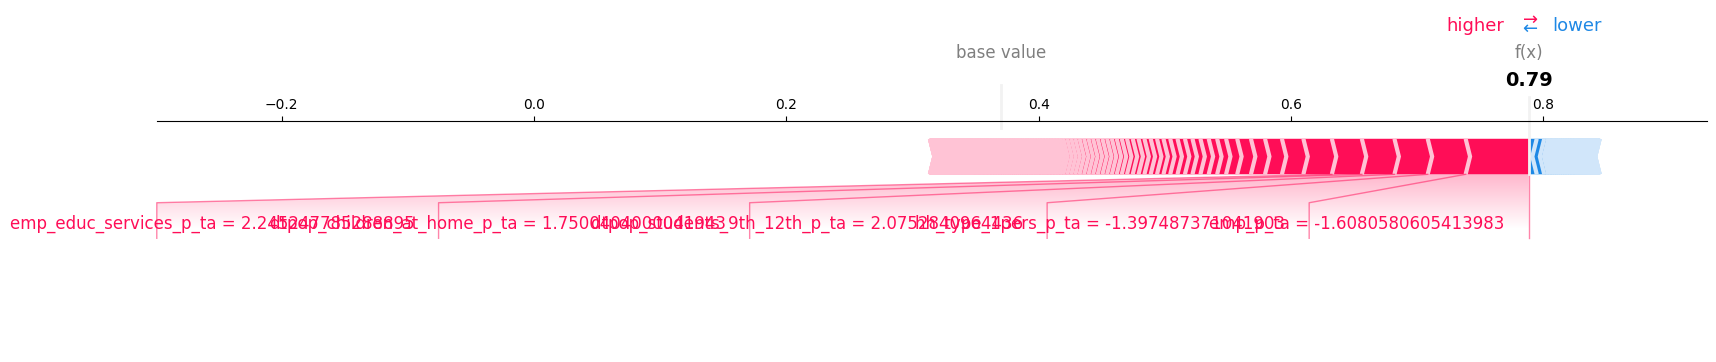

In [132]:
# showing force plot for actual class = 0
shap.force_plot(
    rf_explainer.expected_value[0], 
    test_rf_shap_values[0][class_0_indices[0], :], 
    X_test_enc.iloc[class_0_indices[0], :], 
    matplotlib=True,
)

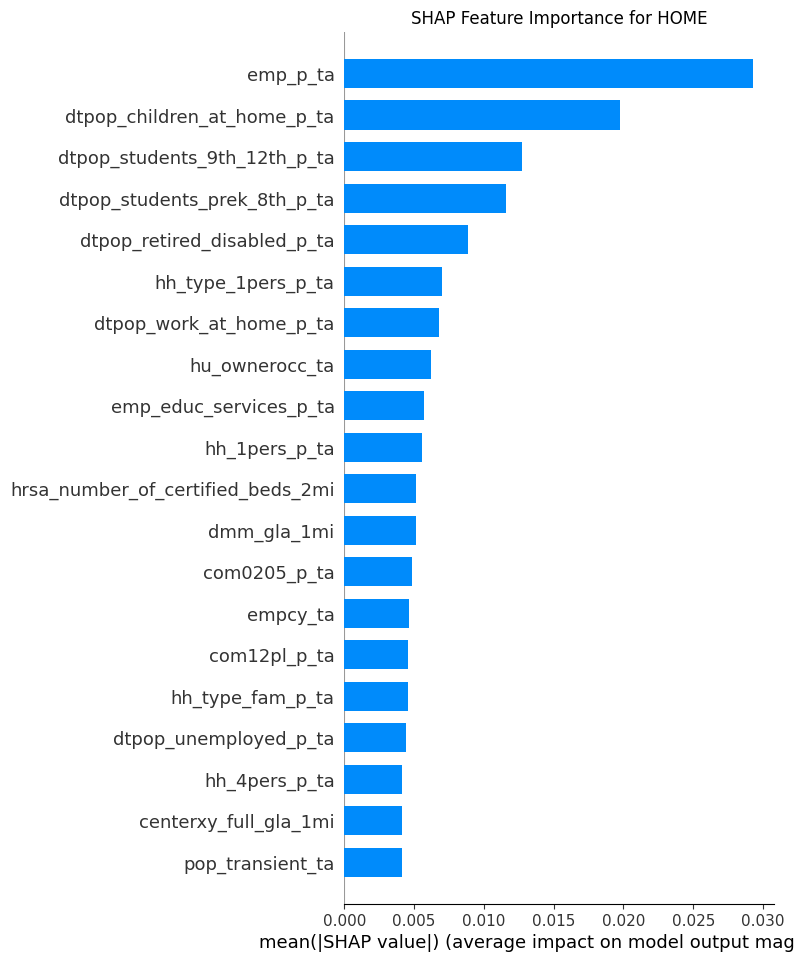

In [133]:
shap.summary_plot(test_rf_shap_values[0], X_test_enc, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for HOME")
plt.show()

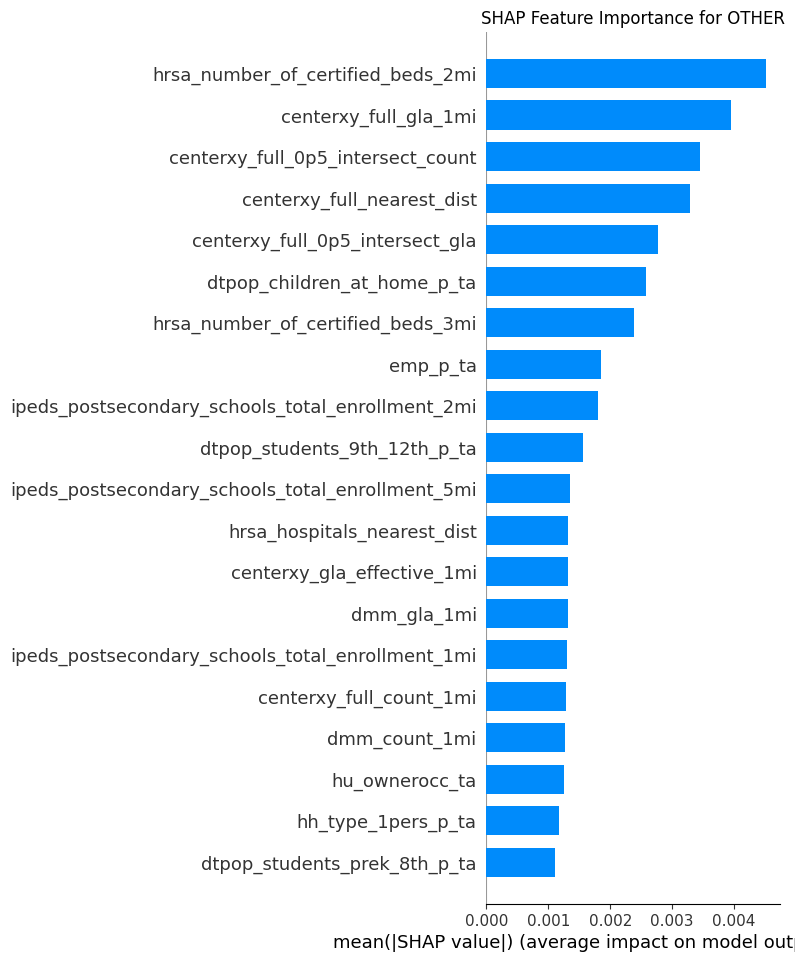

In [134]:
shap.summary_plot(test_rf_shap_values[1], X_test_enc, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for OTHER")
plt.show()

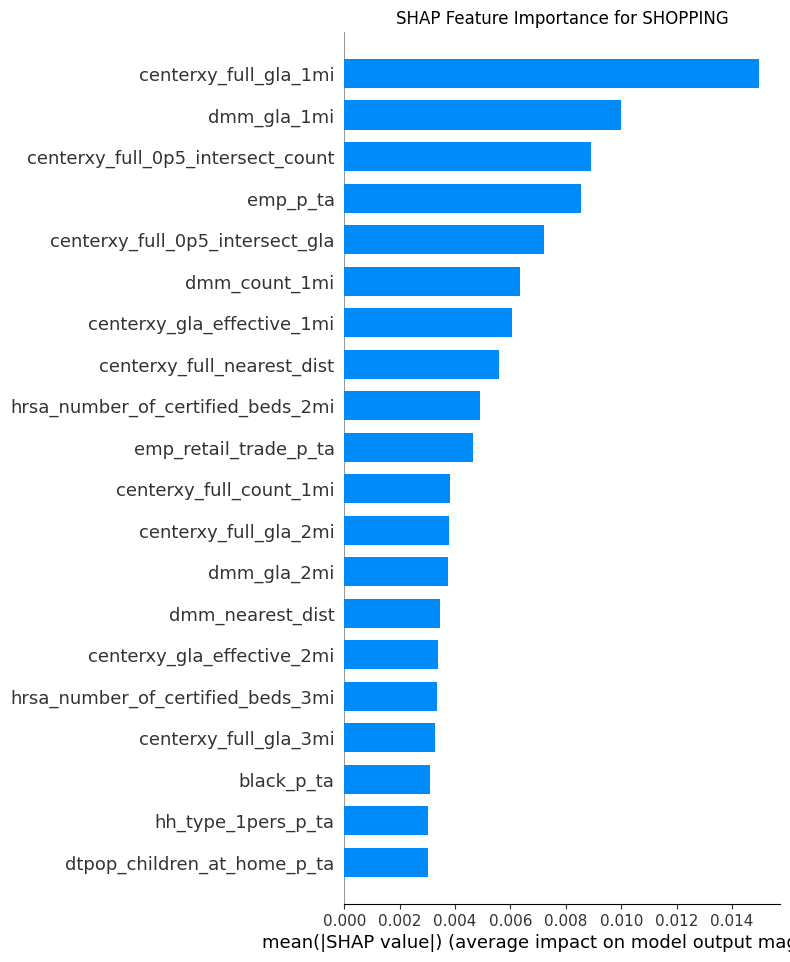

In [135]:
shap.summary_plot(test_rf_shap_values[2], X_test_enc, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for SHOPPING")
plt.show()

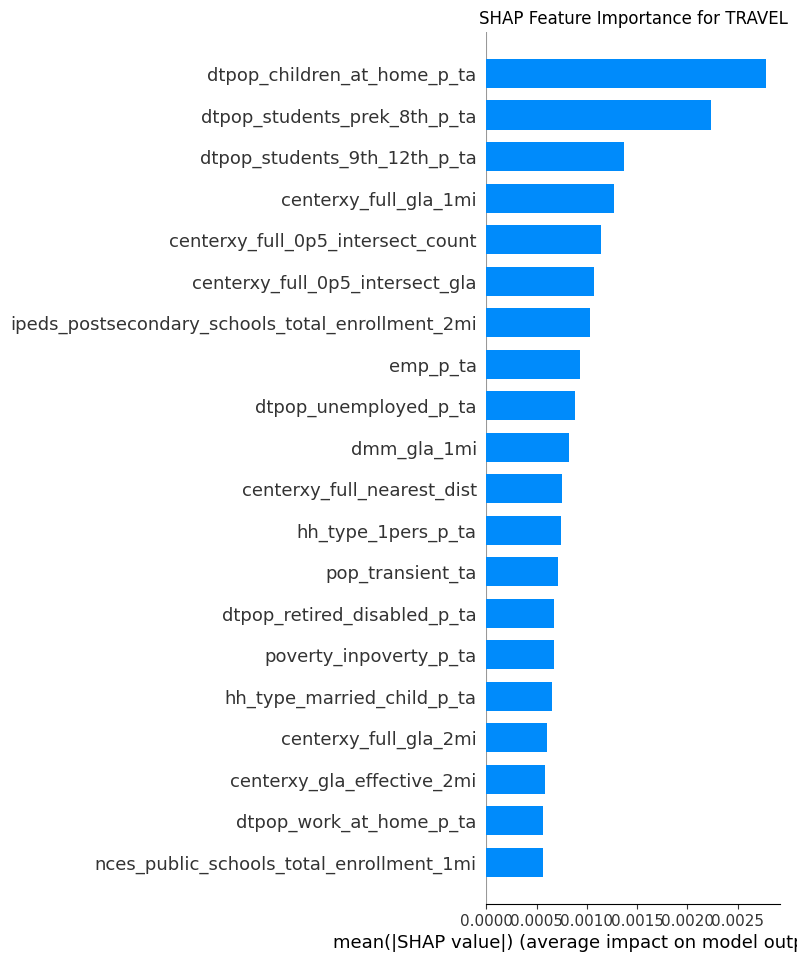

In [136]:
shap.summary_plot(test_rf_shap_values[3], X_test_enc, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for TRAVEL")
plt.show()

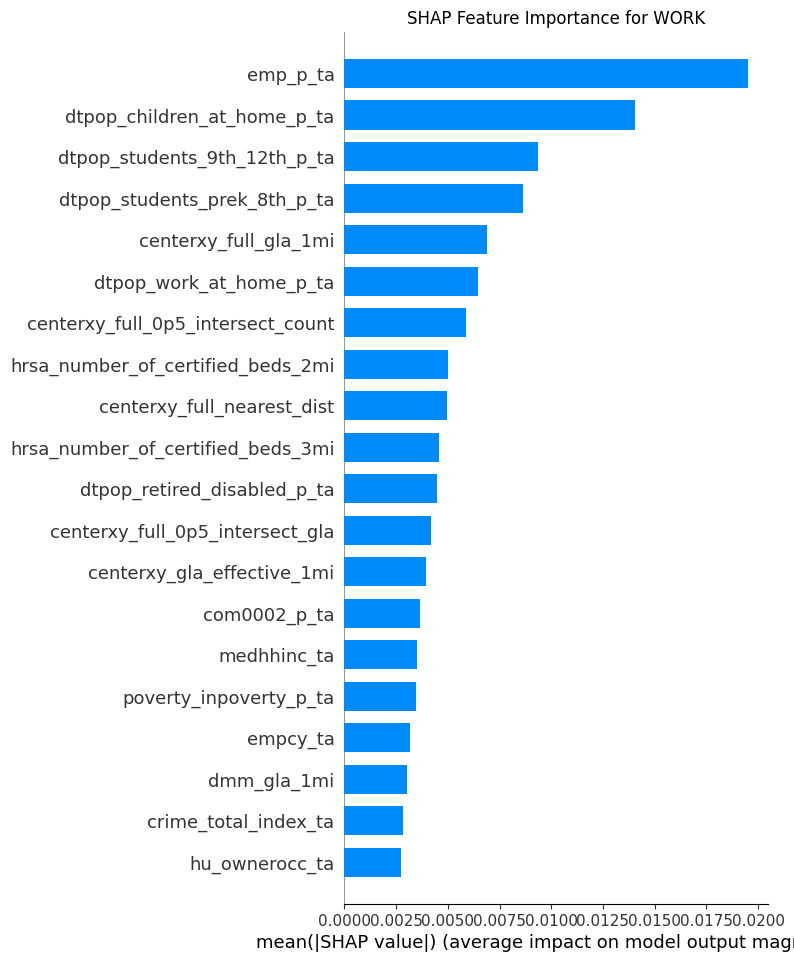

In [137]:
shap.summary_plot(test_rf_shap_values[4], X_test_enc, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for WORK")
plt.show()

## Interpretation for Random Forest (OVR) with L1 Regularization

In [138]:
X_test_enc = pd.DataFrame(
    data=lr_rf_ovr.named_steps["selectfrommodel"].transform(preprocessor.transform(X_test)),
    columns=lr_rf_ovr_selected_features,
    index=X_test.index,
)
X_test_enc

,age0018_p_ta,age85pl_p_ta,black_p_ta,com0002_p_ta,com0205_p_ta,com0508_p_ta,com0811_p_ta,com12pl_p_ta,crime_total_index_ta,daypop_dens_ta,...,nces_public_schools_total_enrollment_10mi,nces_public_schools_total_enrollment_1mi,osm_highway_exits_count_1mi,osm_highway_exits_count_3mi,osm_highway_exits_count_5mi,osm_nearest_exit_dist,transitstop_nearest_dist,transitstops,market_size,store_density
store,,,,,,,,,,,,,,,,,,,,,
SK 1772,-0.757764,0.602321,0.187879,-0.584849,-0.175129,0.661873,0.689044,-0.123595,-0.713232,0.045373,...,0.851272,0.434365,-0.657455,-0.746032,-0.244010,0.459339,-0.297469,-0.562677,5.0,3.0
SK 0762,-0.039123,-0.818166,1.210538,-0.978988,-1.033414,-0.716405,-0.174592,1.161161,-0.631186,-0.406528,...,0.132865,-0.904292,-0.657455,-0.857354,-0.887023,0.622862,-0.213922,-0.562677,5.0,1.0
SK 1054,-1.890643,0.355790,-0.943879,-0.060176,-0.276487,0.044342,0.378899,0.032395,-1.566510,-0.380727,...,-0.020560,0.860148,-0.657455,-0.857354,-0.351179,0.520311,-0.179921,-0.562677,5.0,1.0
SK 0744,-1.981650,4.077230,-0.797614,2.080340,1.743227,-0.225007,-1.267258,-1.156857,-0.188137,0.271832,...,-0.804014,0.335372,-0.657455,-0.857354,-0.994191,1.205616,-0.445713,1.009705,3.0,3.0
SK 1328,0.199378,-0.055095,-0.603393,0.217369,0.056413,0.606690,1.594033,-0.765745,0.501049,-0.572244,...,-0.984476,0.754967,-0.077878,-0.523388,-0.699477,-0.293146,-0.044960,-0.562677,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SK 1169,0.980783,-0.242928,-0.722083,0.245250,1.275494,1.300427,0.248479,-1.229167,1.682512,0.627461,...,2.710409,-0.689432,2.240429,1.981362,1.872574,-0.486390,-0.446298,1.102198,5.0,3.0
SK 1342,-0.183479,0.989726,-0.313260,0.058953,0.664558,0.858958,-0.039400,-0.626128,0.008773,-0.451715,...,-0.879558,-0.904292,-0.077878,-0.189421,-0.431555,-0.525192,-0.443491,0.084774,2.0,0.0
SK 1486,-0.829942,-0.125532,-0.548843,-1.001800,-0.527556,0.238798,0.841731,0.300716,-0.368638,-0.535596,...,-0.967444,-0.210216,-0.077878,-0.634710,-0.726269,-0.458942,-0.268094,-0.562677,3.0,0.0


In [139]:
lr_rf_ovr_estimators = lr_rf_ovr.named_steps["onevsrestclassifier"].estimators_

lr_rf_ovr_explainer_0 = shap.TreeExplainer(lr_rf_ovr_estimators[0])
lr_rf_ovr_explainer_1 = shap.TreeExplainer(lr_rf_ovr_estimators[1])
lr_rf_ovr_explainer_2 = shap.TreeExplainer(lr_rf_ovr_estimators[2])
lr_rf_ovr_explainer_3 = shap.TreeExplainer(lr_rf_ovr_estimators[3])
lr_rf_ovr_explainer_4 = shap.TreeExplainer(lr_rf_ovr_estimators[4])
test_lr_rf_ovr_0_shap_values = lr_rf_ovr_explainer_0.shap_values(X_test_enc)
test_lr_rf_ovr_1_shap_values = lr_rf_ovr_explainer_1.shap_values(X_test_enc)
test_lr_rf_ovr_2_shap_values = lr_rf_ovr_explainer_2.shap_values(X_test_enc)
test_lr_rf_ovr_3_shap_values = lr_rf_ovr_explainer_3.shap_values(X_test_enc)
test_lr_rf_ovr_4_shap_values = lr_rf_ovr_explainer_4.shap_values(X_test_enc)

In [140]:
lr_rf_ovr.named_steps["onevsrestclassifier"].predict(X_test_enc)[class_0_indices[0]]

0

In [141]:
lr_rf_ovr.named_steps["onevsrestclassifier"].predict_proba(X_test_enc)[class_0_indices[0]]

array([0.65843605, 0.09982017, 0.12788772, 0.03880426, 0.07505179])

In [142]:
lr_rf_ovr.named_steps["onevsrestclassifier"].estimators_[0].classes_

array([0, 1], dtype=int32)

**OneVsRest puts the 'rest' class at index=0, and the 'one' class at index=1.**

In [143]:
print(lr_rf_ovr.named_steps["onevsrestclassifier"].estimators_[0].predict_proba(X_test_enc)[class_0_indices[0]])
print(lr_rf_ovr.named_steps["onevsrestclassifier"].estimators_[1].predict_proba(X_test_enc)[class_0_indices[0]])
print(lr_rf_ovr.named_steps["onevsrestclassifier"].estimators_[2].predict_proba(X_test_enc)[class_0_indices[0]])
print(lr_rf_ovr.named_steps["onevsrestclassifier"].estimators_[3].predict_proba(X_test_enc)[class_0_indices[0]])
print(lr_rf_ovr.named_steps["onevsrestclassifier"].estimators_[4].predict_proba(X_test_enc)[class_0_indices[0]])
print(lr_rf_ovr.named_steps["onevsrestclassifier"].predict_proba(X_test_enc)[class_0_indices[0]])

[0.24286651 0.75713349]
[0.88521711 0.11478289]
[0.85294232 0.14705768]
[0.9553791 0.0446209]
[0.91369819 0.08630181]
[0.65843605 0.09982017 0.12788772 0.03880426 0.07505179]


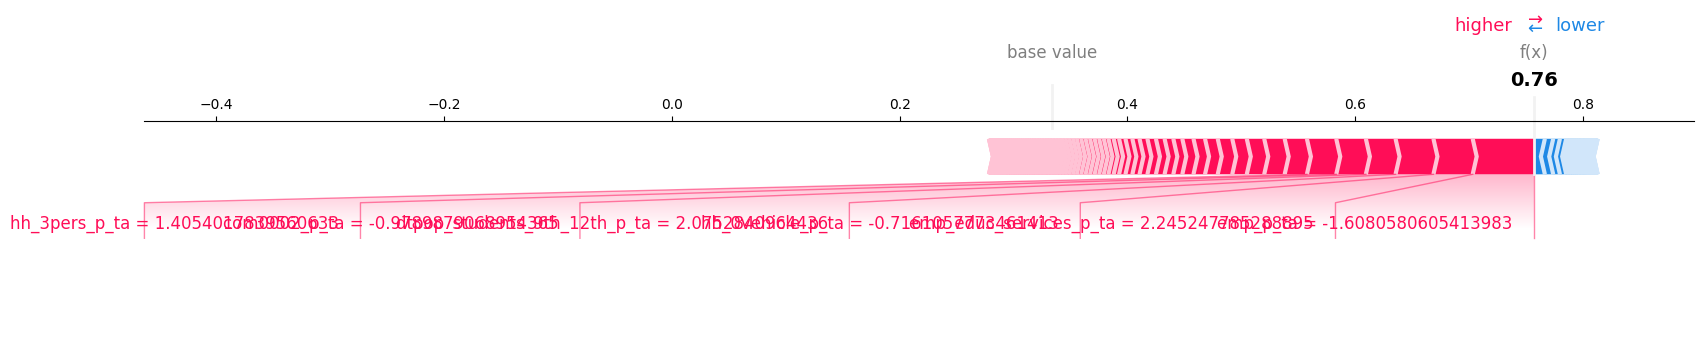

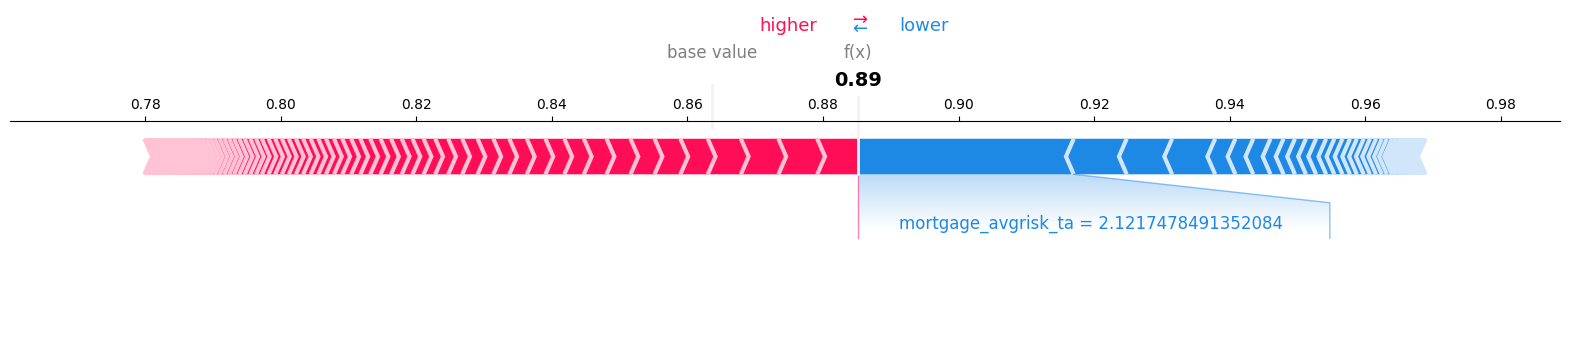

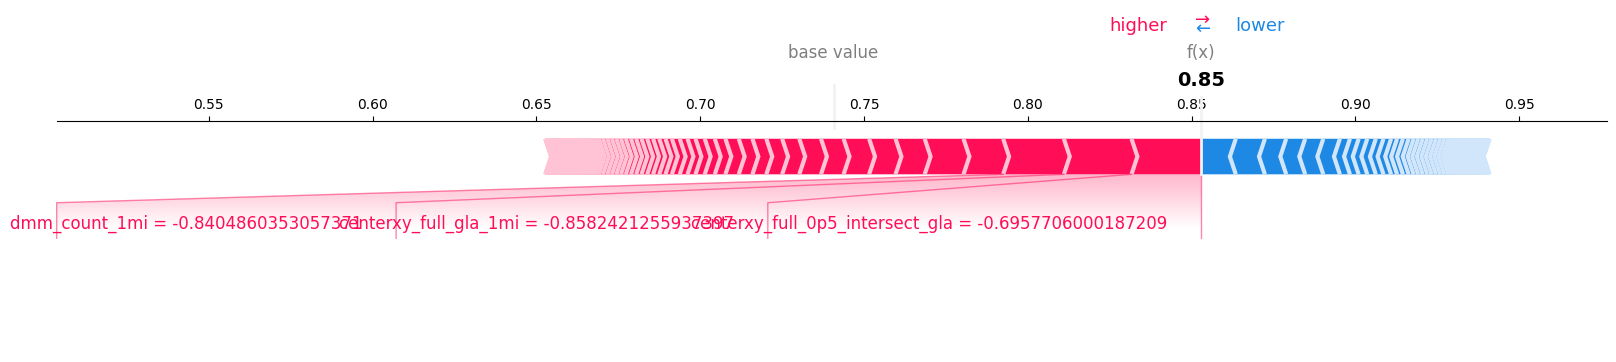

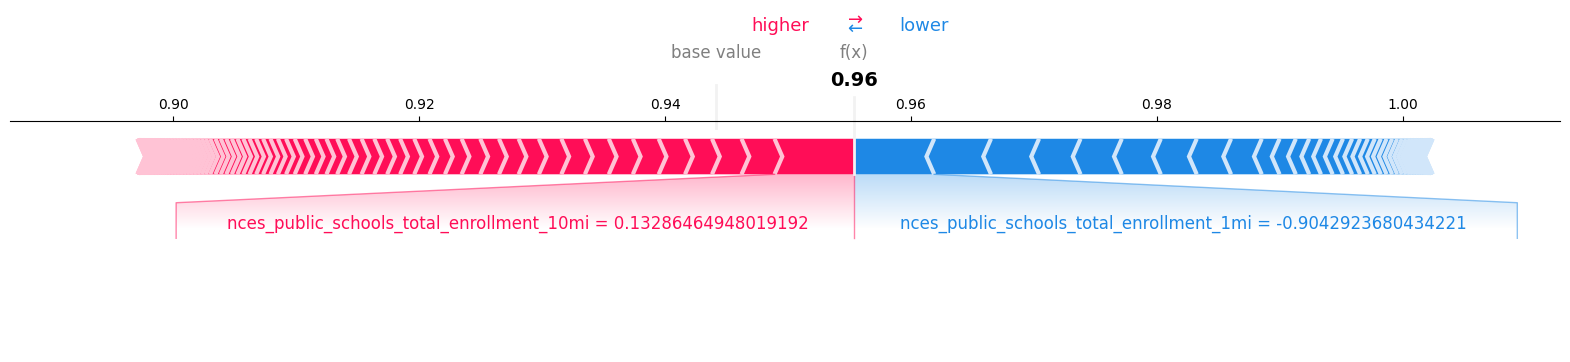

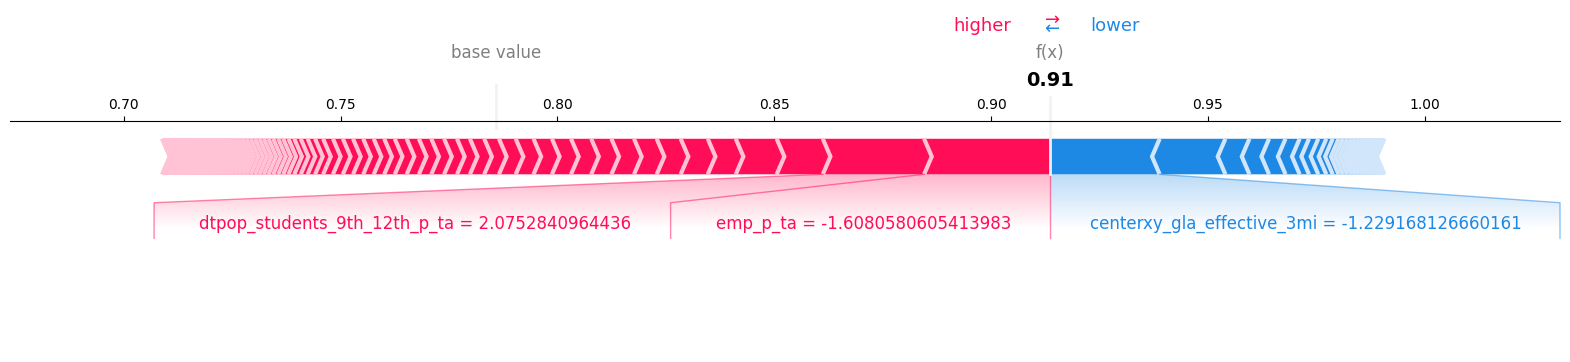

In [144]:
# showing force plot for actual class = 0 (HOME)

shap.force_plot(
    lr_rf_ovr_explainer_0.expected_value[1], 
    test_lr_rf_ovr_0_shap_values[1][class_0_indices[0], :],
    X_test_enc.iloc[class_0_indices[0], :],
    matplotlib=True,
)
shap.force_plot(
    lr_rf_ovr_explainer_1.expected_value[0], 
    test_lr_rf_ovr_1_shap_values[0][class_0_indices[0], :],
    X_test_enc.iloc[class_0_indices[0], :],
    matplotlib=True,
)
shap.force_plot(
    lr_rf_ovr_explainer_2.expected_value[0], 
    test_lr_rf_ovr_2_shap_values[0][class_0_indices[0], :],
    X_test_enc.iloc[class_0_indices[0], :],
    matplotlib=True,
)
shap.force_plot(
    lr_rf_ovr_explainer_3.expected_value[0], 
    test_lr_rf_ovr_3_shap_values[0][class_0_indices[0], :],
    X_test_enc.iloc[class_0_indices[0], :],
    matplotlib=True,
)
shap.force_plot(
    lr_rf_ovr_explainer_4.expected_value[0], 
    test_lr_rf_ovr_4_shap_values[0][class_0_indices[0], :],
    X_test_enc.iloc[class_0_indices[0], :],
    matplotlib=True,
)

In [145]:
lr_rf_ovr.named_steps["onevsrestclassifier"].predict(X_test_enc)[class_4_indices[0]]

4

In [146]:
lr_rf_ovr.named_steps["onevsrestclassifier"].predict_proba(X_test_enc)[class_4_indices[0]]

array([0.25826263, 0.11576385, 0.13813915, 0.08451743, 0.40331694])

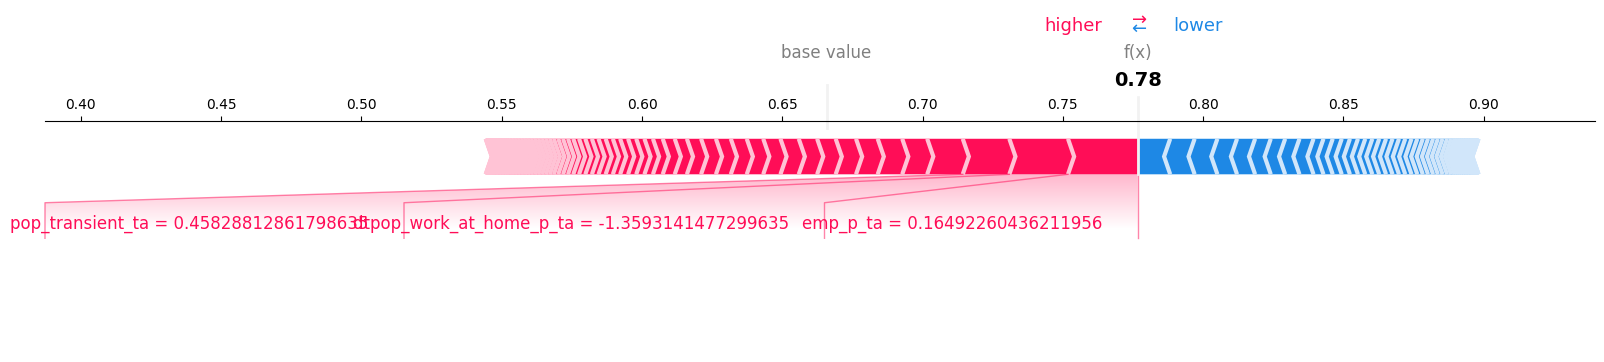

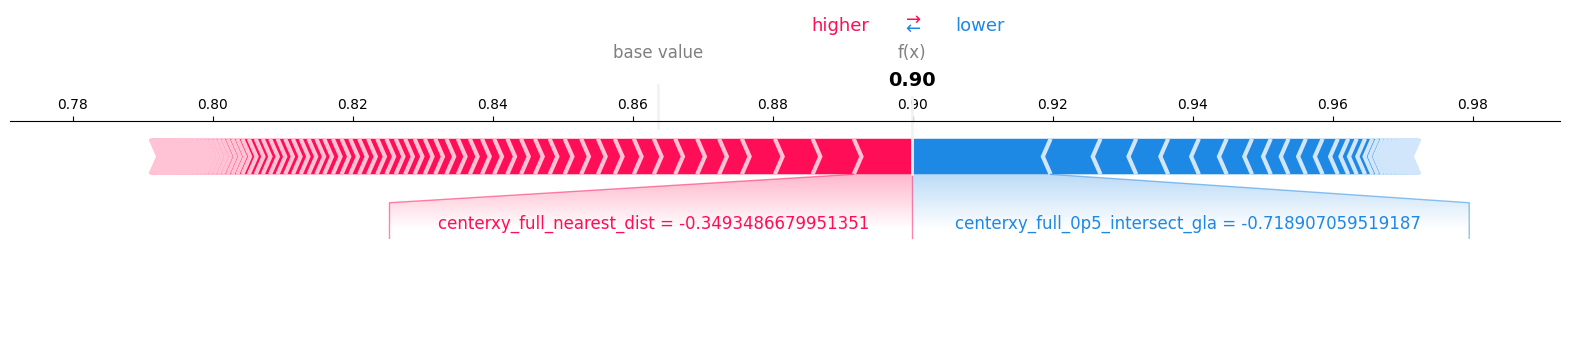

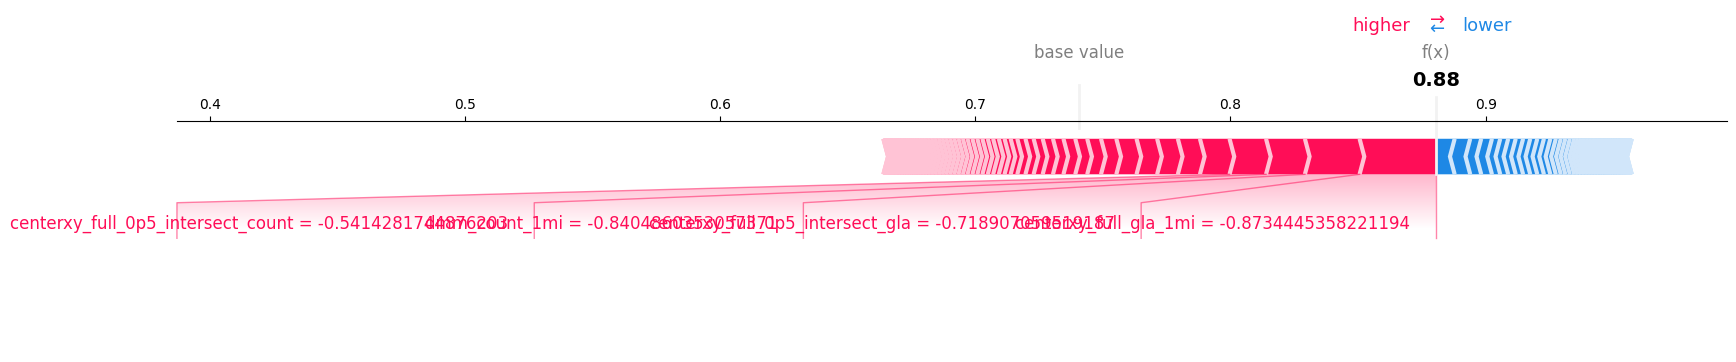

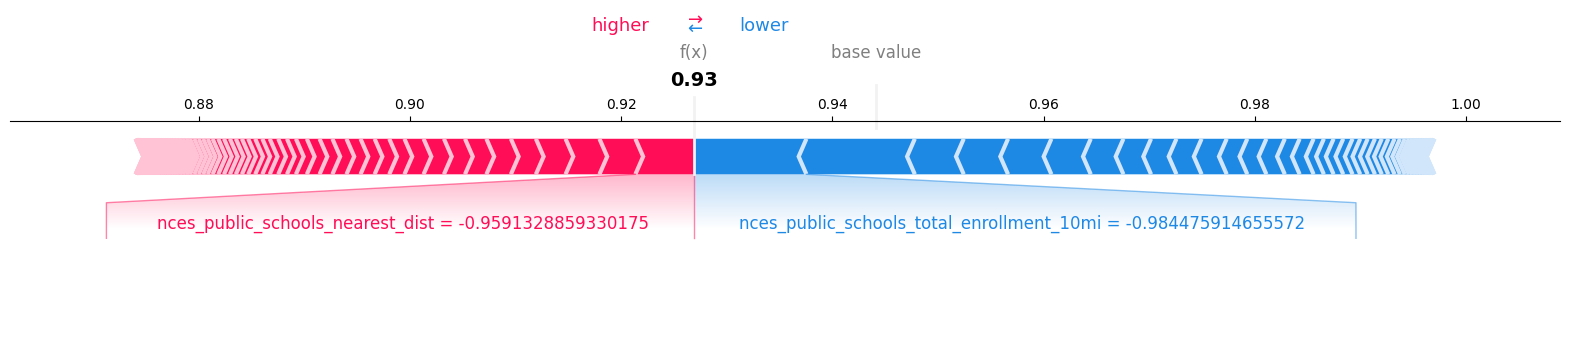

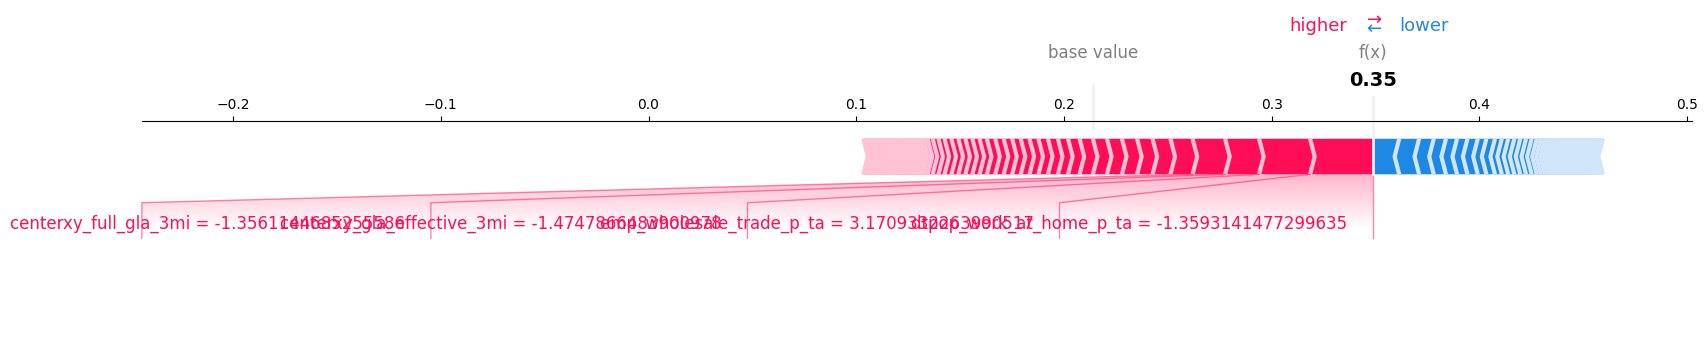

In [147]:
# showing force plot for actual class = 4 (WORK)
# expected_value[0] = predicted class; expected_value[1] = 'rest' of the classes
shap.force_plot(
    lr_rf_ovr_explainer_0.expected_value[0], 
    test_lr_rf_ovr_0_shap_values[0][class_4_indices[0], :],
    X_test_enc.iloc[class_4_indices[0], :],
    matplotlib=True,
)
shap.force_plot(
    lr_rf_ovr_explainer_1.expected_value[0], 
    test_lr_rf_ovr_1_shap_values[0][class_4_indices[0], :],
    X_test_enc.iloc[class_4_indices[0], :],
    matplotlib=True,
)
shap.force_plot(
    lr_rf_ovr_explainer_2.expected_value[0], 
    test_lr_rf_ovr_2_shap_values[0][class_4_indices[0], :],
    X_test_enc.iloc[class_4_indices[0], :],
    matplotlib=True,
)
shap.force_plot(
    lr_rf_ovr_explainer_3.expected_value[0], 
    test_lr_rf_ovr_3_shap_values[0][class_4_indices[0], :],
    X_test_enc.iloc[class_4_indices[0], :],
    matplotlib=True,
)
shap.force_plot(
    lr_rf_ovr_explainer_4.expected_value[1], 
    test_lr_rf_ovr_4_shap_values[1][class_4_indices[0], :],
    X_test_enc.iloc[class_4_indices[0], :],
    matplotlib=True,
)

In [148]:
print(lr_rf_ovr.named_steps["onevsrestclassifier"].estimators_[0].predict_proba(X_test_enc)[class_4_indices[0]])
print(lr_rf_ovr.named_steps["onevsrestclassifier"].estimators_[1].predict_proba(X_test_enc)[class_4_indices[0]])
print(lr_rf_ovr.named_steps["onevsrestclassifier"].estimators_[2].predict_proba(X_test_enc)[class_4_indices[0]])
print(lr_rf_ovr.named_steps["onevsrestclassifier"].estimators_[3].predict_proba(X_test_enc)[class_4_indices[0]])
print(lr_rf_ovr.named_steps["onevsrestclassifier"].estimators_[4].predict_proba(X_test_enc)[class_4_indices[0]])
print(lr_rf_ovr.named_steps["onevsrestclassifier"].predict_proba(X_test_enc)[class_4_indices[0]])

[0.7766481 0.2233519]
[0.89988457 0.10011543]
[0.88053385 0.11946615]
[0.92690724 0.07309276]
[0.65120155 0.34879845]
[0.25826263 0.11576385 0.13813915 0.08451743 0.40331694]


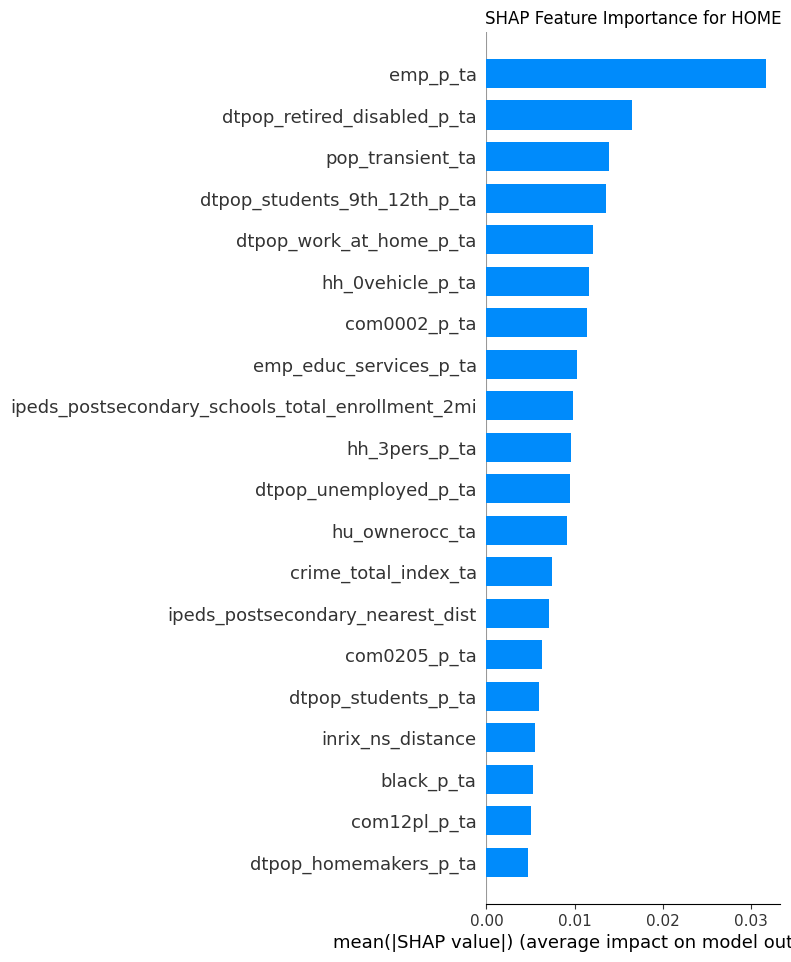

In [149]:
shap.summary_plot(test_lr_rf_ovr_0_shap_values[0], X_test_enc, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for HOME")
plt.show()

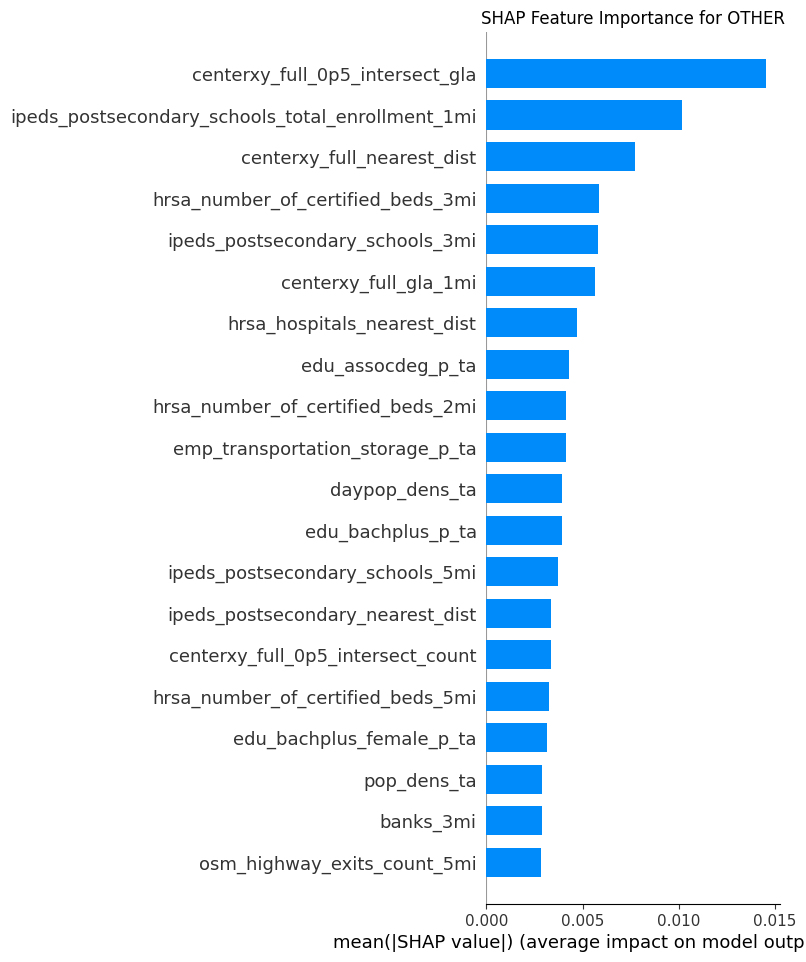

In [150]:
shap.summary_plot(test_lr_rf_ovr_1_shap_values[0], X_test_enc, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for OTHER")
plt.show()

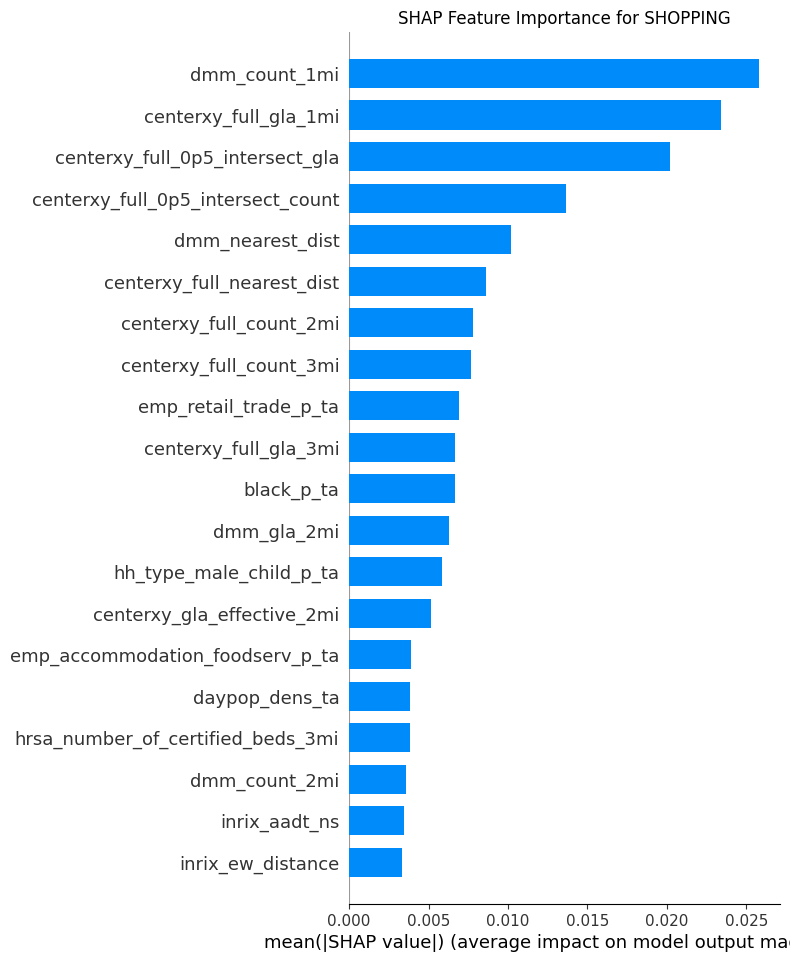

In [151]:
shap.summary_plot(test_lr_rf_ovr_2_shap_values[0], X_test_enc, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for SHOPPING")
plt.show()

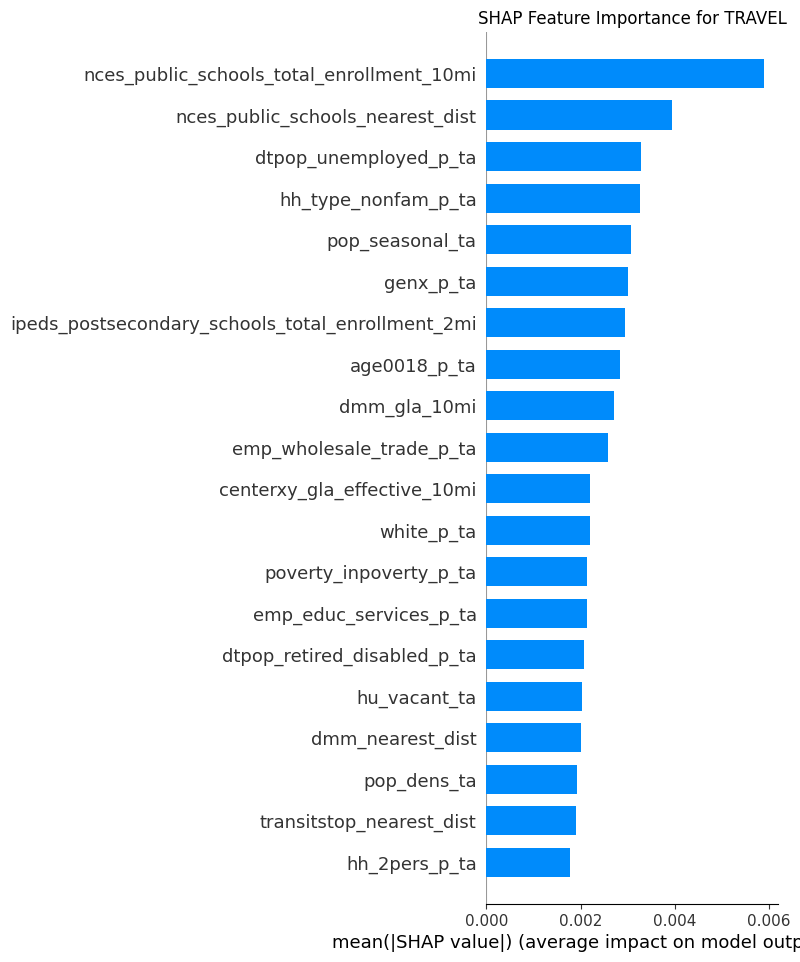

In [152]:
shap.summary_plot(test_lr_rf_ovr_3_shap_values[0], X_test_enc, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for TRAVEL")
plt.show()

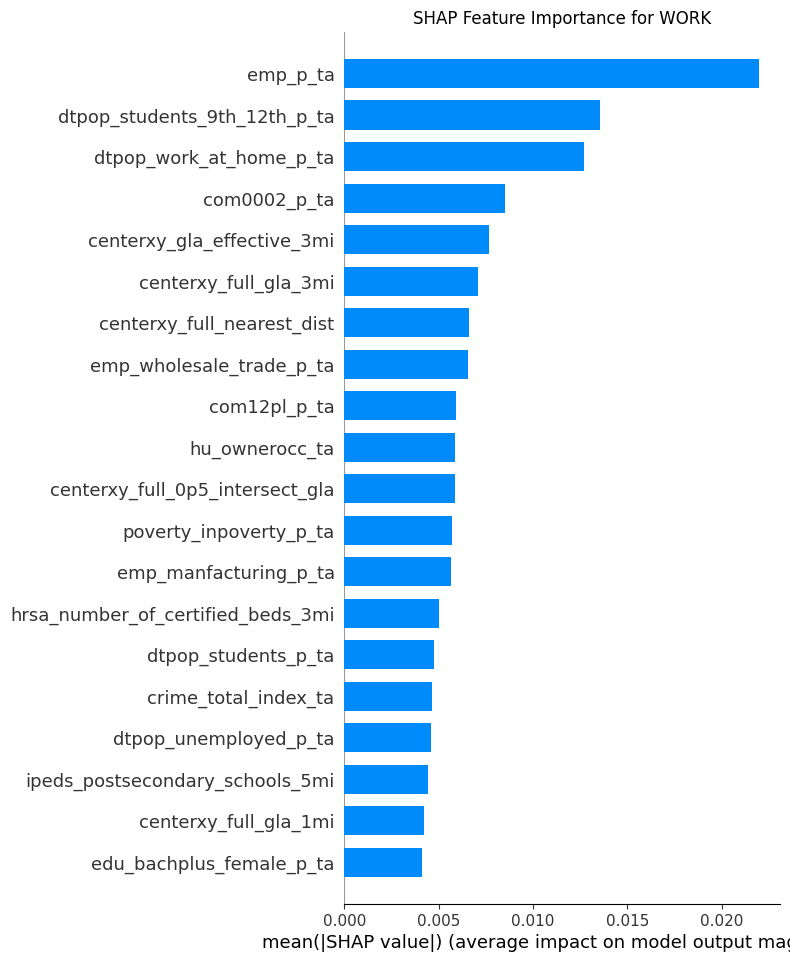

In [153]:
shap.summary_plot(test_lr_rf_ovr_4_shap_values[0], X_test_enc, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for WORK")
plt.show()

## SHAP for Random Forest with L1 regularization

In [154]:
X_test_enc = pd.DataFrame(
    data=lr_rf_l1.named_steps["selectfrommodel"].transform(preprocessor.transform(X_test)),
    columns=lr_rf_l1_selected_features,
    index=X_test.index,
)
X_test_enc

,age0018_p_ta,black_p_ta,com0205_p_ta,crime_total_index_ta,daypop_dens_ta,dtpop_retired_disabled_p_ta,dtpop_unemployed_p_ta,dtpop_work_at_home_p_ta,edu_assocdeg_p_ta,edu_bachplus_male_p_ta,...,nces_private_schools_total_enrollment_2mi,nces_public_schools_nearest_dist,nces_public_schools_total_enrollment_10mi,nces_public_schools_total_enrollment_2mi,nces_public_schools_total_enrollment_3mi,osm_highway_exits_count_3mi,transitstop_nearest_dist,transitstops,market_size,store_density
store,,,,,,,,,,,,,,,,,,,,,
SK 1772,-0.757764,0.187879,-0.175129,-0.713232,0.045373,0.731713,0.079602,-0.607458,1.246056,-0.783197,...,-0.527008,-0.214299,0.851272,0.015845,0.166248,-0.746032,-0.297469,-0.562677,5.0,3.0
SK 0762,-0.039123,1.210538,-1.033414,-0.631186,-0.406528,0.446705,0.555232,2.060556,1.738635,-0.386767,...,-0.710909,0.981259,0.132865,1.047455,0.442722,-0.857354,-0.213922,-0.562677,5.0,1.0
SK 1054,-1.890643,-0.943879,-0.276487,-1.566510,-0.380727,1.156431,0.683781,1.042328,-0.205980,1.349573,...,1.017940,-1.098851,-0.020560,-0.418182,-0.288970,-0.857354,-0.179921,-0.562677,5.0,1.0
SK 0744,-1.981650,-0.797614,1.743227,-0.188137,0.271832,1.333396,-0.473158,-0.079011,0.218066,0.033763,...,0.797633,-0.726836,-0.804014,0.620672,-0.155351,-0.857354,-0.445713,1.009705,3.0,3.0
SK 1328,0.199378,-0.603393,0.056413,0.501049,-0.572244,0.014536,-0.357464,-1.359314,0.380831,-1.571237,...,-0.445794,-0.959133,-0.984476,-0.198205,-0.594553,-0.523388,-0.044960,-0.562677,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SK 1169,0.980783,-0.722083,1.275494,1.682512,0.627461,-0.957844,0.041037,-0.469976,-1.276803,0.369945,...,0.463439,0.134216,2.710409,-0.697655,0.519176,1.981362,-0.446298,1.102198,5.0,3.0
SK 1342,-0.183479,-0.313260,0.664558,0.008773,-0.451715,0.144932,-0.563142,-0.732052,0.796311,0.351871,...,-0.555013,0.974663,-0.879558,-1.010497,-1.109858,-0.189421,-0.443491,0.084774,2.0,0.0
SK 1486,-0.829942,-0.548843,-0.527556,-0.368638,-0.535596,1.236531,0.053892,0.741586,0.732061,0.006049,...,-0.597021,0.143787,-0.967444,-0.719608,-0.884237,-0.634710,-0.268094,-0.562677,3.0,0.0


In [155]:
lr_rf_l1_explainer = shap.TreeExplainer(lr_rf_l1.named_steps["randomforestclassifier"])
test_lr_rf_l1_shap_values = lr_rf_l1_explainer.shap_values(X_test_enc)
test_lr_rf_l1_shap_values

[array([[ 4.54089558e-03, -6.78692038e-03, -3.60219896e-03, ...,
         -9.98037923e-04,  1.38861722e-03,  2.32359491e-03],
        [-1.07654232e-03, -6.73630621e-03,  1.55301709e-02, ...,
         -5.03767616e-04,  2.73165188e-03, -2.22134058e-04],
        [-1.83565813e-03,  8.79465774e-03, -2.69534799e-03, ...,
         -3.56700859e-04,  4.51595792e-03, -2.67413465e-04],
        ...,
        [ 6.02811177e-03,  2.20583291e-03,  4.35658403e-03, ...,
         -5.37566419e-04, -2.71901164e-03, -1.08494387e-04],
        [ 5.49625376e-04, -3.64301019e-03, -2.27011705e-03, ...,
         -1.67777047e-04,  2.37596371e-03,  1.43501771e-03],
        [-1.03935139e-03, -2.09900781e-03, -9.05543756e-03, ...,
         -7.00751302e-04,  9.96869488e-04, -5.96070508e-05]]),
 array([[-4.82287400e-04,  4.06192589e-04, -4.11602718e-04, ...,
          6.77604555e-05,  1.06807028e-04,  6.80739871e-05],
        [-3.27655992e-04, -3.25238490e-04, -2.90790522e-03, ...,
         -4.17375725e-05, -4.47467613e

In [156]:
lr_rf_l1.named_steps["randomforestclassifier"].predict(X_test_enc)[class_0_indices[0]]

0

In [157]:
lr_rf_l1.named_steps["randomforestclassifier"].predict_proba(X_test_enc)[class_0_indices[0]]

array([0.67011949, 0.05358914, 0.16750147, 0.02077034, 0.08801957])

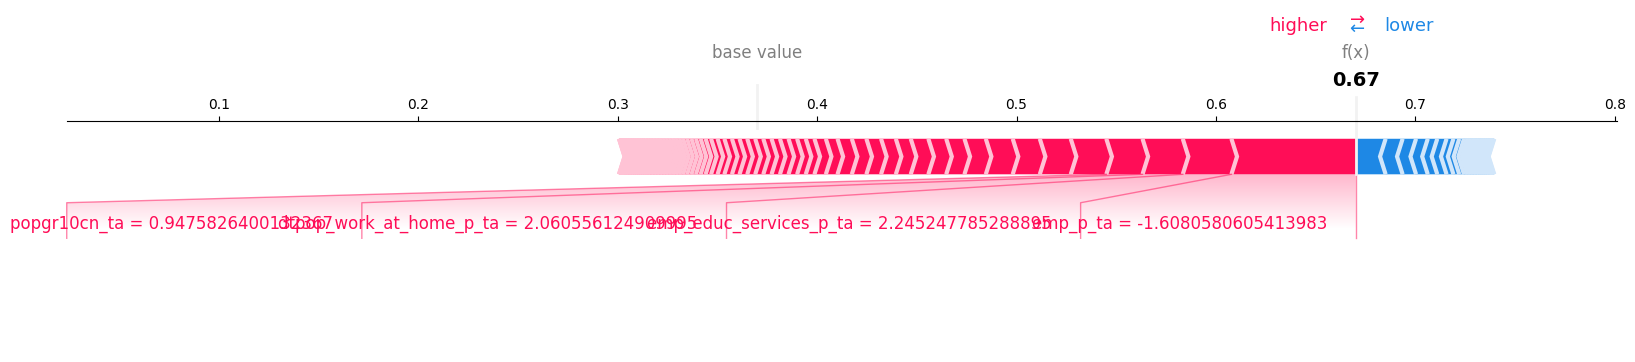

In [158]:
shap.force_plot(
    lr_rf_l1_explainer.expected_value[0], 
    test_lr_rf_l1_shap_values[0][class_0_indices[0], :],
    X_test_enc.iloc[class_0_indices[0], :],
    matplotlib=True,
)

In [159]:
lr_rf_l1.named_steps["randomforestclassifier"].predict(X_test_enc)[class_1_indices[4]]

1

In [160]:
lr_rf_l1.named_steps["randomforestclassifier"].predict_proba(X_test_enc)[class_1_indices[4]]

array([0.15529091, 0.34592189, 0.15900108, 0.07155835, 0.26822776])

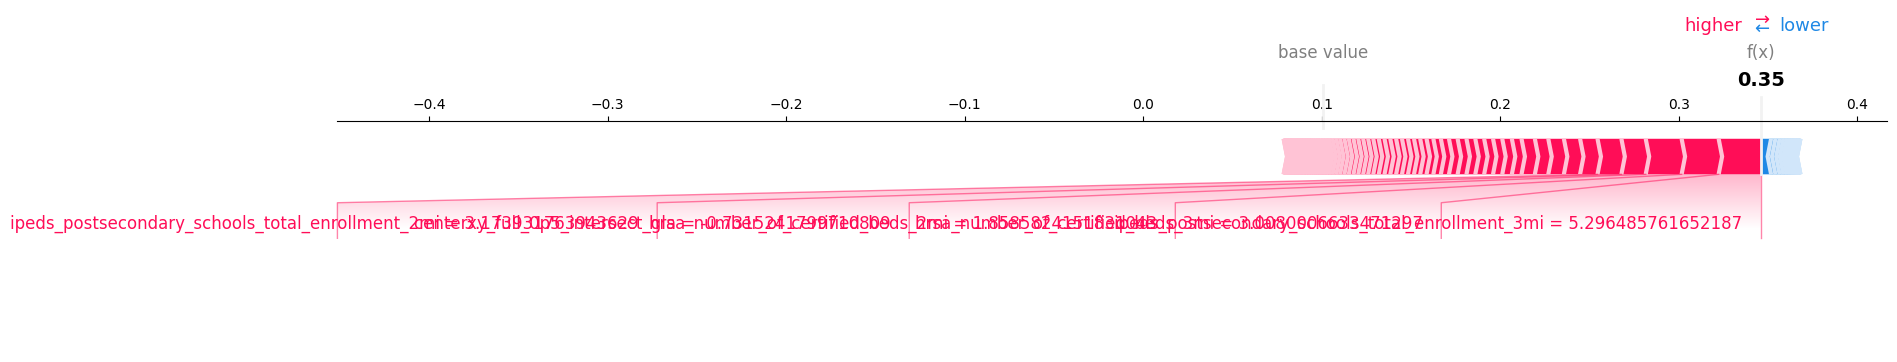

In [161]:
shap.force_plot(
    lr_rf_l1_explainer.expected_value[1], 
    test_lr_rf_l1_shap_values[1][class_1_indices[4], :],
    X_test_enc.iloc[class_1_indices[4], :],
    matplotlib=True,
)

In [162]:
lr_rf_l1.named_steps["randomforestclassifier"].predict(X_test_enc)[class_2_indices[1]]

2

In [163]:
lr_rf_l1.named_steps["randomforestclassifier"].predict_proba(X_test_enc)[class_2_indices[1]]

array([0.16477299, 0.03821111, 0.60960472, 0.02887546, 0.15853572])

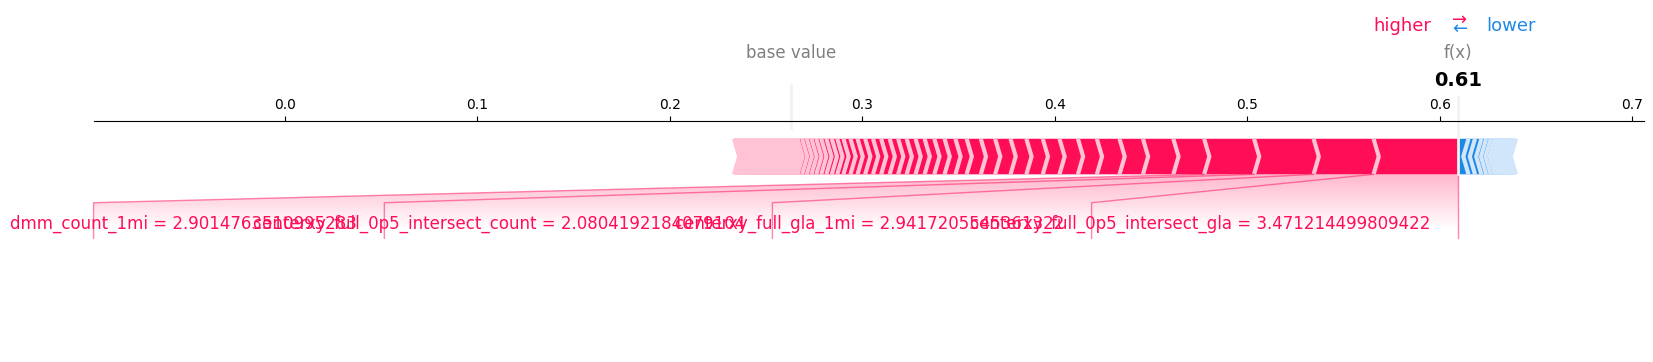

In [164]:
shap.force_plot(
    lr_rf_l1_explainer.expected_value[2], 
    test_lr_rf_l1_shap_values[2][class_2_indices[1], :],
    X_test_enc.iloc[class_2_indices[1], :],
    matplotlib=True,
)

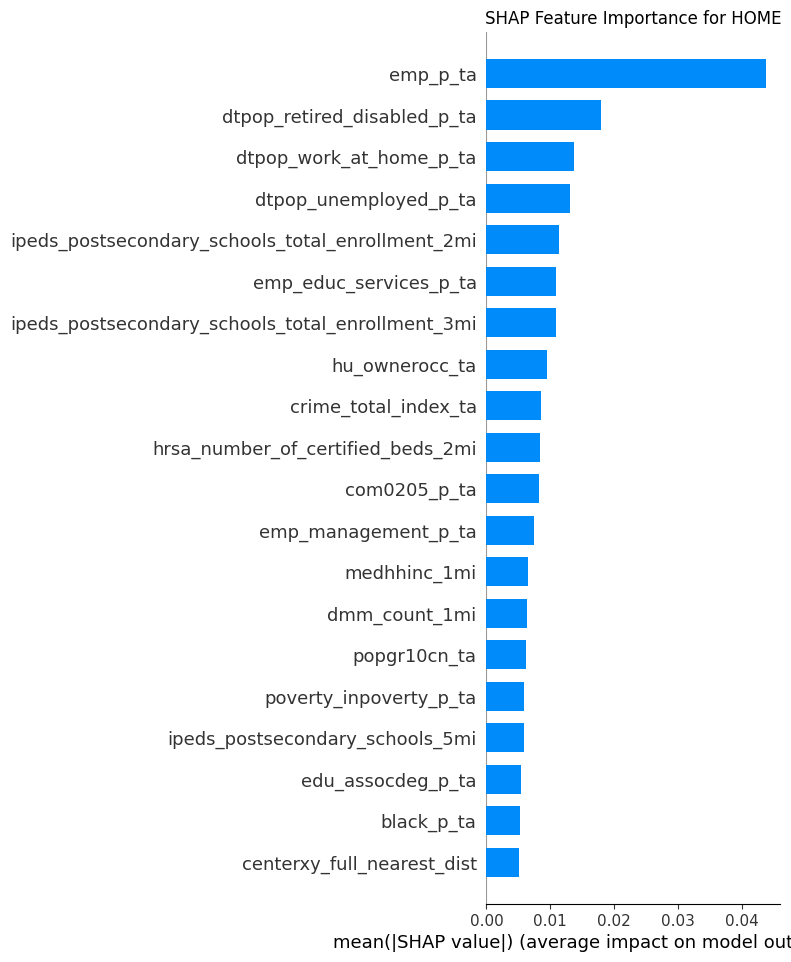

In [165]:
shap.summary_plot(test_lr_rf_l1_shap_values[0], X_test_enc, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for HOME")
plt.show()

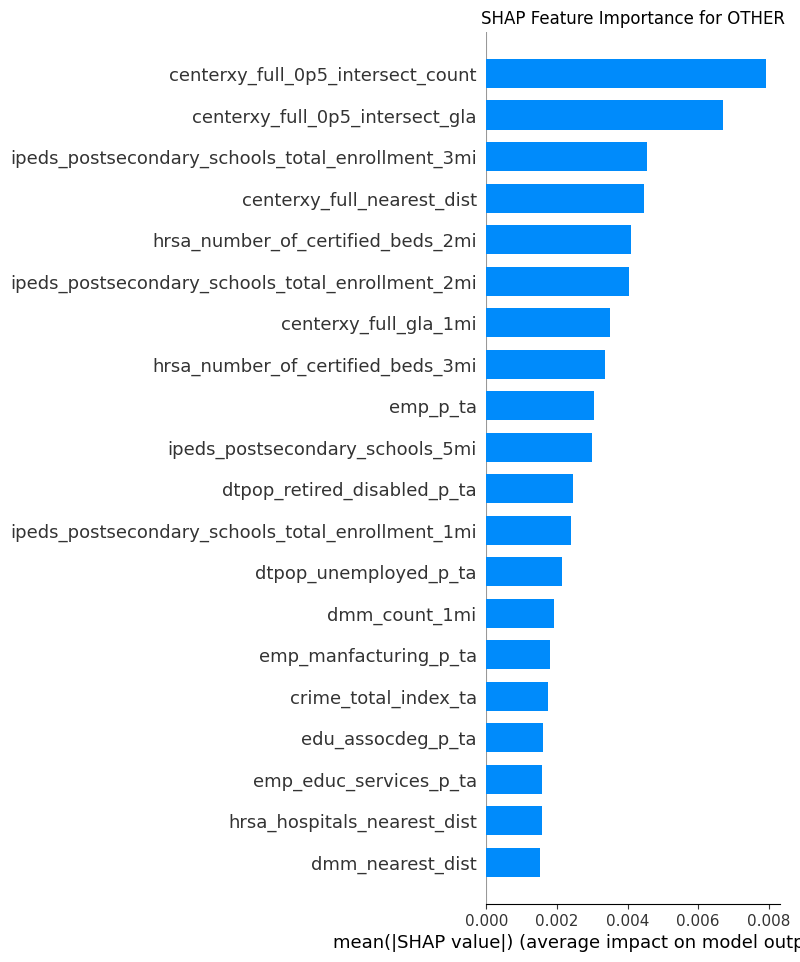

In [166]:
shap.summary_plot(test_lr_rf_l1_shap_values[1], X_test_enc, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for OTHER")
plt.show()

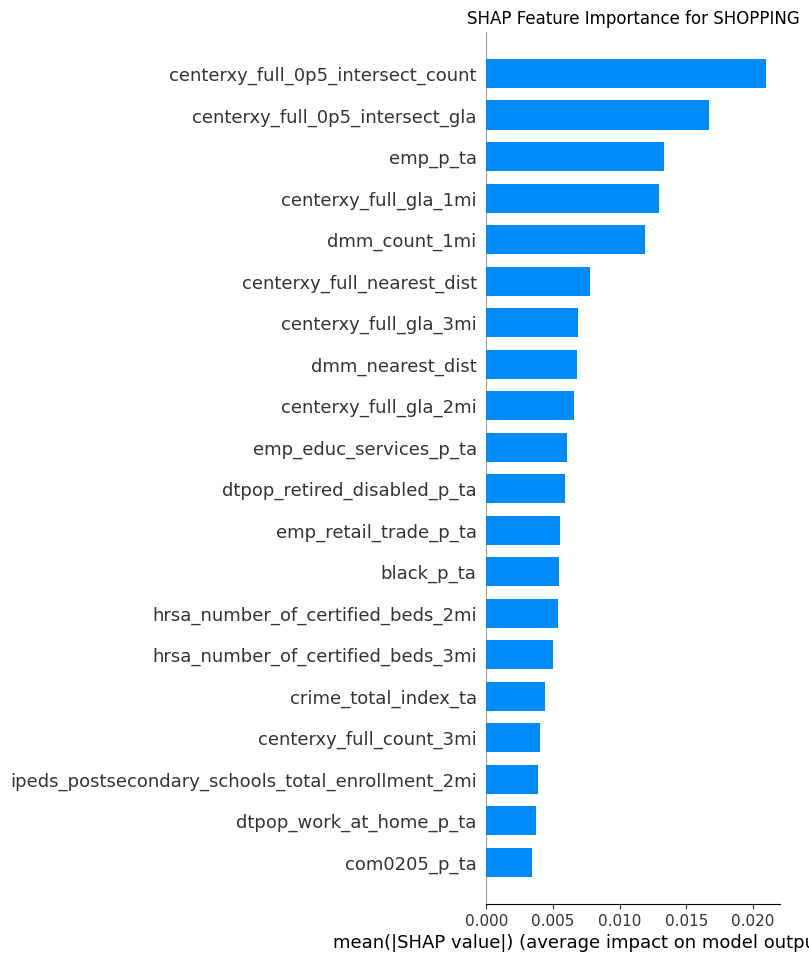

In [167]:
shap.summary_plot(test_lr_rf_l1_shap_values[2], X_test_enc, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for SHOPPING")
plt.show()

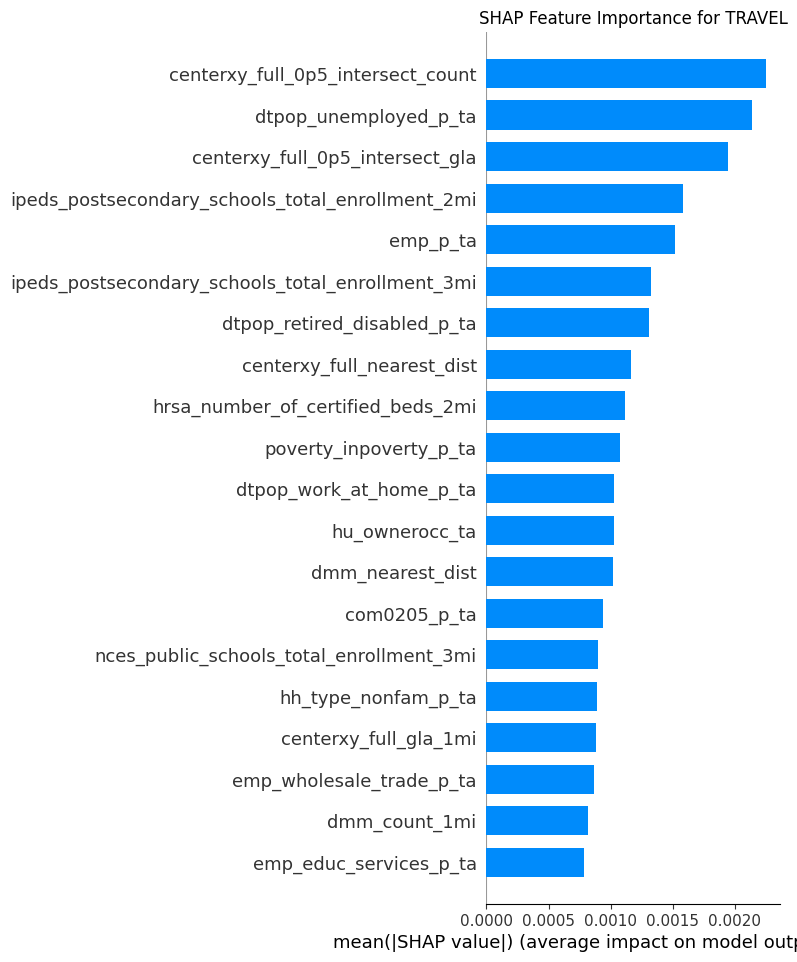

In [168]:
shap.summary_plot(test_lr_rf_l1_shap_values[3], X_test_enc, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for TRAVEL")
plt.show()

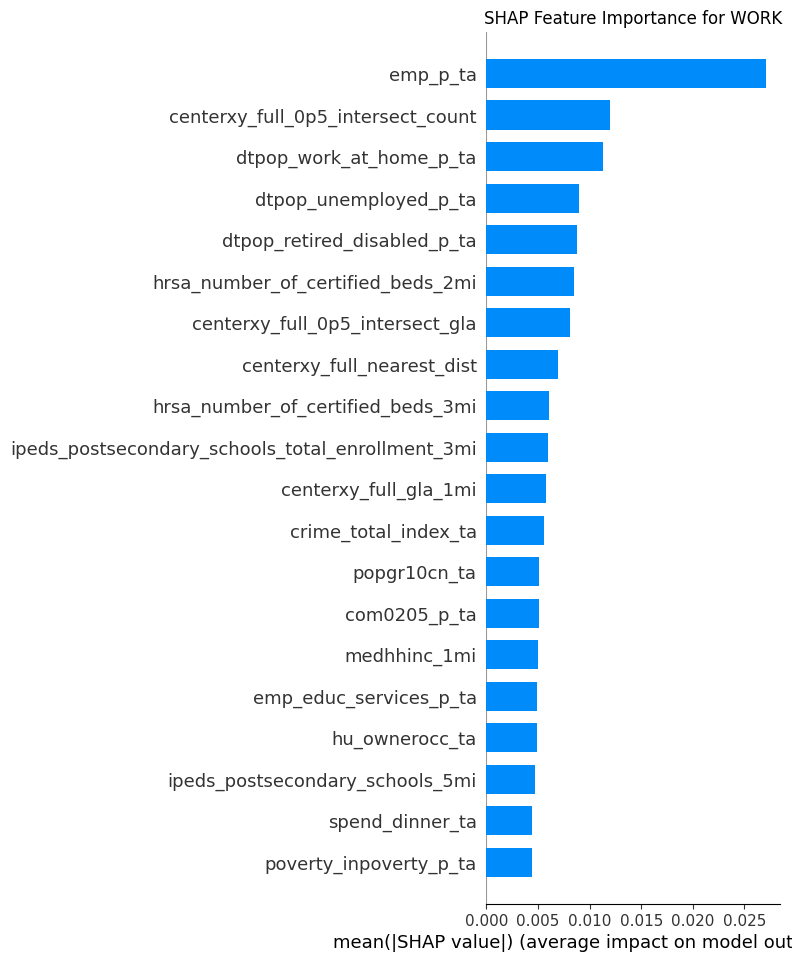

In [169]:
shap.summary_plot(test_lr_rf_l1_shap_values[4], X_test_enc, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for WORK")
plt.show()